In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
import warnings
import importlib
import os
import scipy
warnings.filterwarnings("ignore")
import fit_pkpd
importlib.reload(fit_pkpd)

<module 'fit_pkpd' from '/Users/harshparikh/Documents/GitHub/iic_causal_inference/aim2/fit_pkpd.py'>

### path to Sahar's data

In [64]:
data_folder_path = '/Users/harshparikh/Documents/RCT_sim_code/'
cnn_labels = 'CNN_Label/'
drug = 'Combined_Drug_Normalize/'
# patients = list(map(lambda x: x.replace('.mat',''), os.listdir( data_folder_path+drug )))
patients = ['sid1158', 'sid871', 'sid708', 'sid287', 'sid1832', 'sid286', 'sid1211', 'sid1577', 'sid877', 'sid320', 
            'sid861', 'sid350', 'sid967', 'sid1112', 'sid351', 'sid345', 'sid353', 'sid804', 'sid958', 'sid970', 
            'sid742', 'sid959', 'sid949', 'sid341', 'sid962', 'sid1117', 'sid1881', 'sid826', 'sid1127', 'sid1118', 
            'sid1125', 'sid1119', 'sid1535', 'sid834', 'sid1486', 'sid1109', 'sid1532', 'sid716', 'sid1144', 'sid850', 
            'sid846', 'sid1194', 'sid922', 'sid854', 'sid868', 'sid920', 'sid855', 'sid699']

### path to git iic data


In [65]:
path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle')

iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'sids', 'pseudoMRNs'])

### getting Sahar's cohort from IIC

In [66]:
idxs = pd.DataFrame(iic_burden['sids'])
idxs = idxs.reset_index()
patients_idx = idxs.set_index(0).loc[patients].values.T[0]
patients_idx

array([ 796,  588,  488,  183, 1215,  182,  824, 1052,  593,  208,  582,
        231,  663,  759,  232,  228,  234,  541,  658,  665,  514,  659,
        650,  225,  660,  764, 1247,  555,  774,  765,  772,  766, 1028,
        560,  997,  756, 1026,  492,  786,  573,  570,  814,  626,  577,
        586,  624,  578,  482])

### fitting PD model

In [385]:
import fit_pkpd
importlib.reload(fit_pkpd)

<module 'fit_pkpd' from '/Users/harshparikh/Documents/GitHub/iic_causal_inference/aim2/fit_pkpd.py'>

In [386]:
columns = []
drugs_interest = ['levetiracetam','propofol']
for drug in drugs_interest:
    for i in ['50','B','Hill']:
        columns += [drug+'_'+str(i)]
columns = columns + ['baseline_avg','baseline_heavytail_mu','baseline_heavytail_sigma']

In [387]:
pd_param_df = pd.DataFrame()
for i in tqdm.tqdm(patients_idx):
    D = iic_burden['D'][i]
    D = pd.DataFrame(D,columns=iic_burden['Dname'])[drugs_interest]
    E = pd.Series(iic_burden['Pobs'][i])
    E = E.interpolate(method='linear')
    pd_params = pd.DataFrame( np.array([fit_pkpd.fit_PD(E,D)]), index=[iic_burden['sids'][i]], columns=columns)
    pd_param_df = pd_param_df.append(pd_params)
pd_param_df = pd_param_df

100%|██████████| 48/48 [05:21<00:00,  6.70s/it]


In [391]:
pd_param_df.to_csv('pd_params_lev_prop_sahardata.csv')

Text(0.5, 0, 'Time Steps (1 Step = 10 min)')

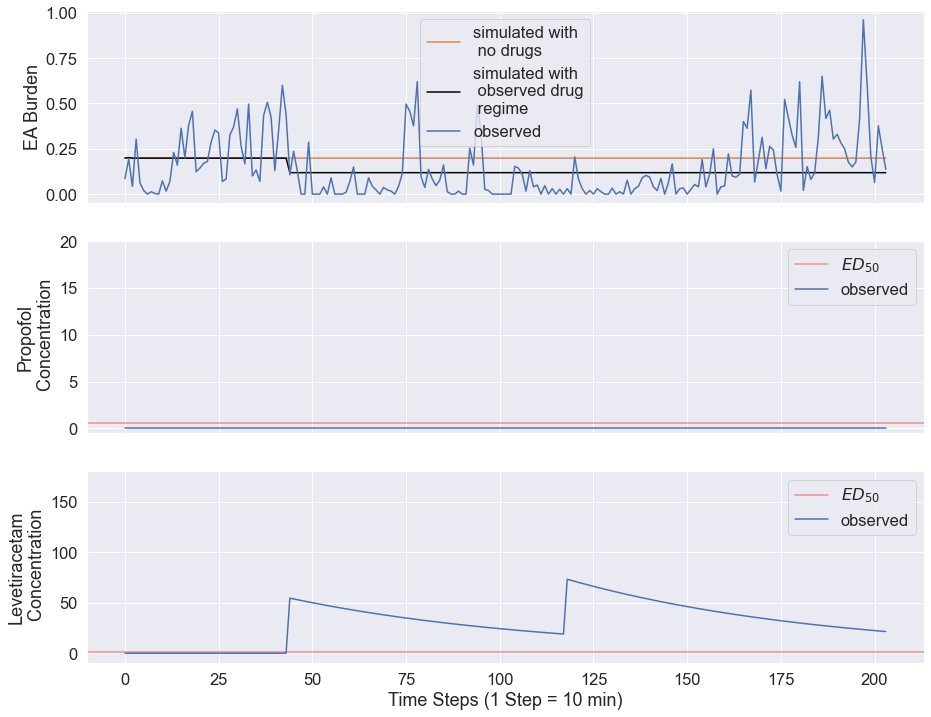

In [392]:
sns.set(font_scale=1.5)
j = 0

i = patients_idx[j]
D = iic_burden['D'][i]
D = pd.DataFrame(D,columns=iic_burden['Dname'])[drugs_interest]
E = pd.Series(iic_burden['Pobs'][i])
E = E.interpolate(method='linear')

E_sim = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                     D_=D.values,
                     Timesteps=iic_burden['D'][i].shape[0])
E_sim0 = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                     D_=np.zeros_like(D.values),
                     Timesteps=iic_burden['D'][i].shape[0])

fig,ax = plt.subplots(nrows=3,figsize=(15,12),sharex=True)


ax[0].plot(E_sim0,c='C1')
ax[0].plot(E_sim,c='black')
ax[0].plot(E)
ax[0].legend(['simulated with\n no drugs','simulated with\n observed drug\n regime','observed'])
ax[0].set_ylabel('EA Burden')

ax[1].axhline(pd_param_df['propofol_50'].iloc[j],c='red',alpha=0.4)
ax[1].plot(D['propofol'])
ax[1].legend([r'$ED_{50}$','observed'])
ax[1].set_ylabel('Propofol\n Concentration')
ax[1].set_ylim((-0.5,20))

ax[2].axhline(pd_param_df['levetiracetam_50'].iloc[j],c='red',alpha=0.4)
ax[2].plot(D['levetiracetam'])
ax[2].set_ylabel('Levetiracetam\n Concentration')
ax[2].set_ylim((-10,180))
ax[2].legend([r'$ED_{50}$','observed'])
ax[2].set_xlabel('Time Steps (1 Step = 10 min)')

# plt.savefig('/Users/harshparikh/Documents/RCT_sim_code/HillPD_Figures/'+patients[j]+'_Hill_PD_w_lognormal_baseline.png')

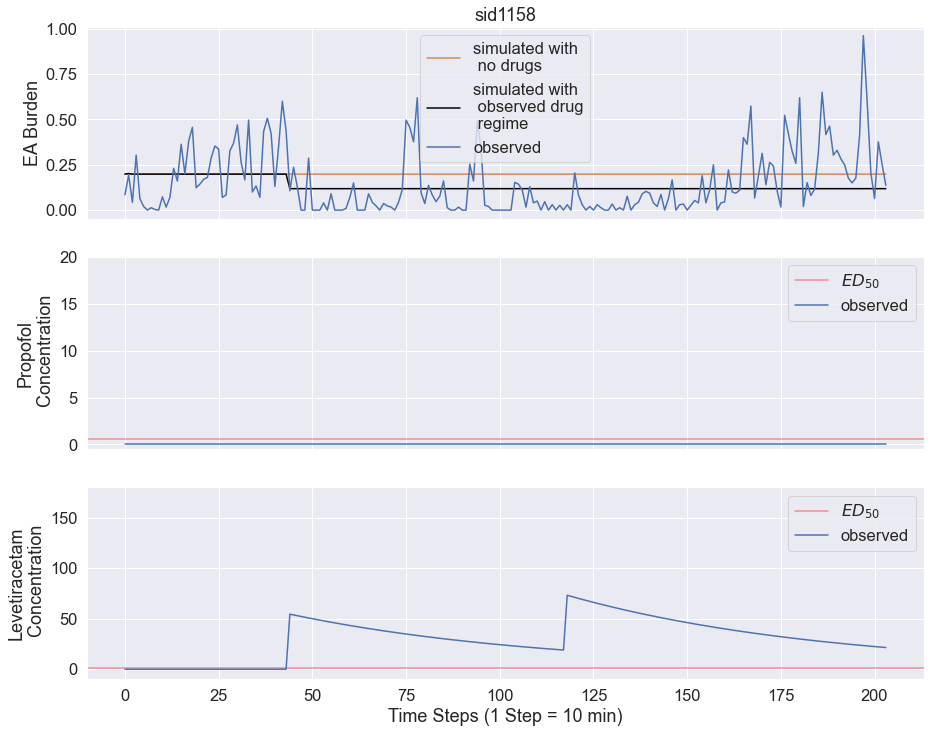

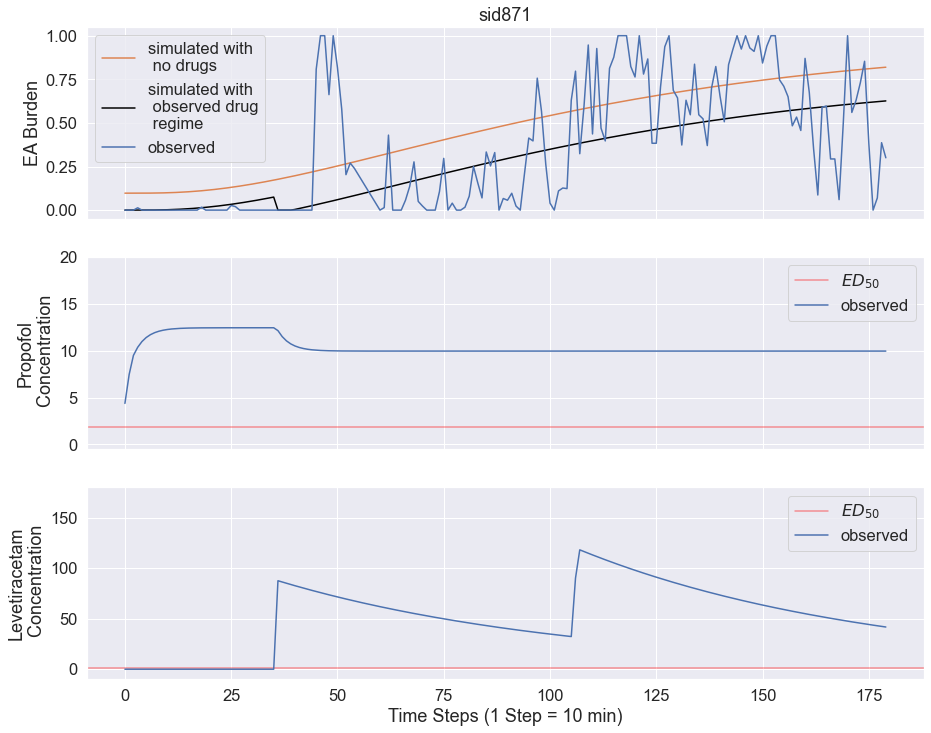

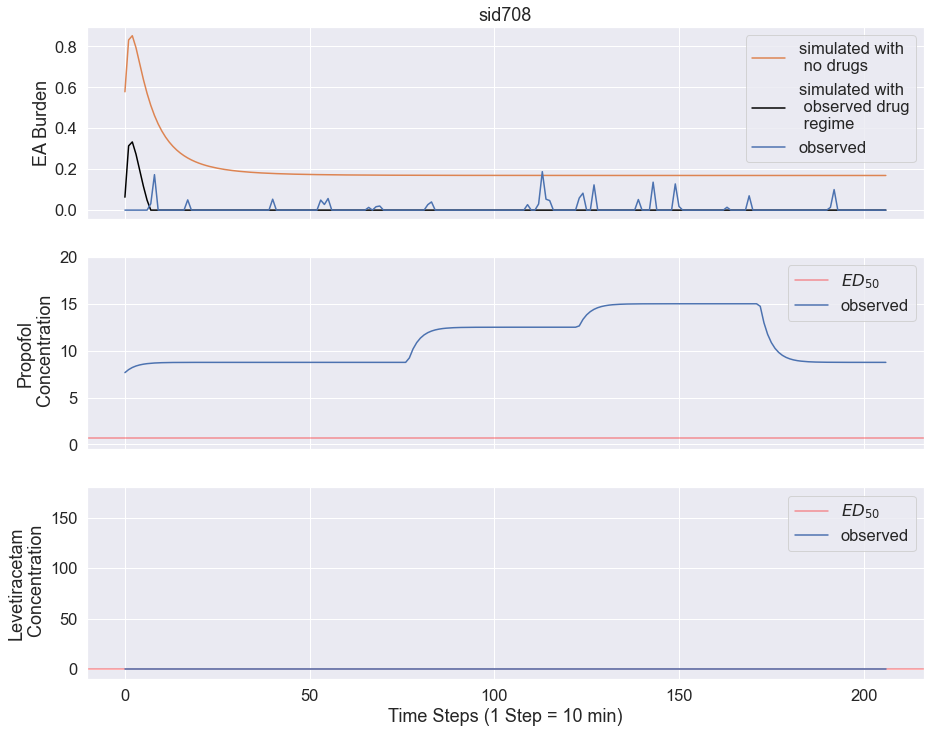

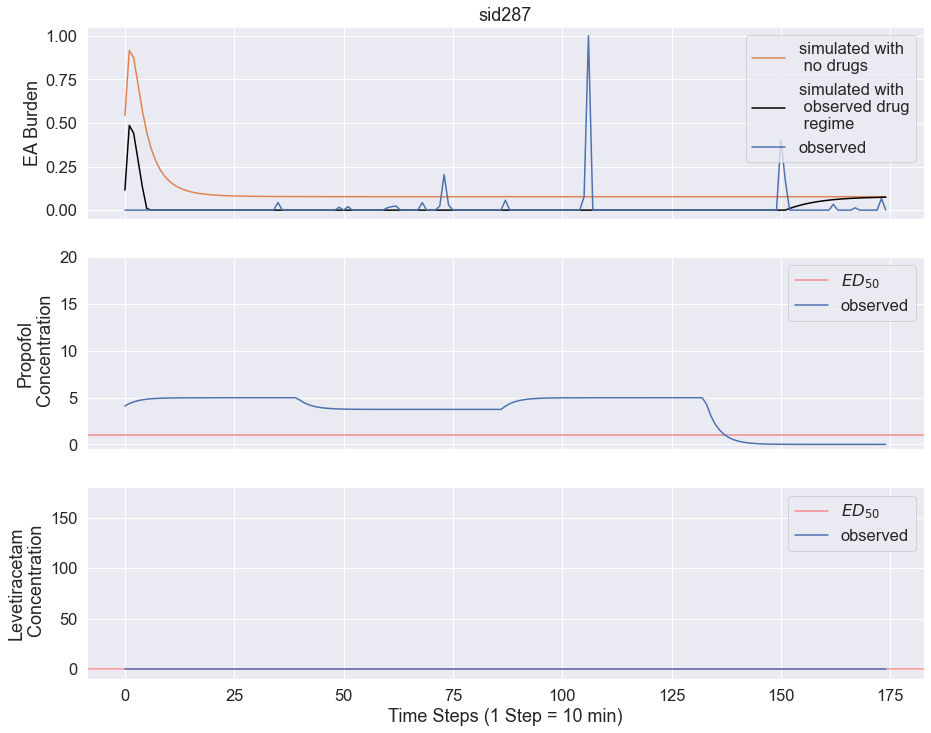

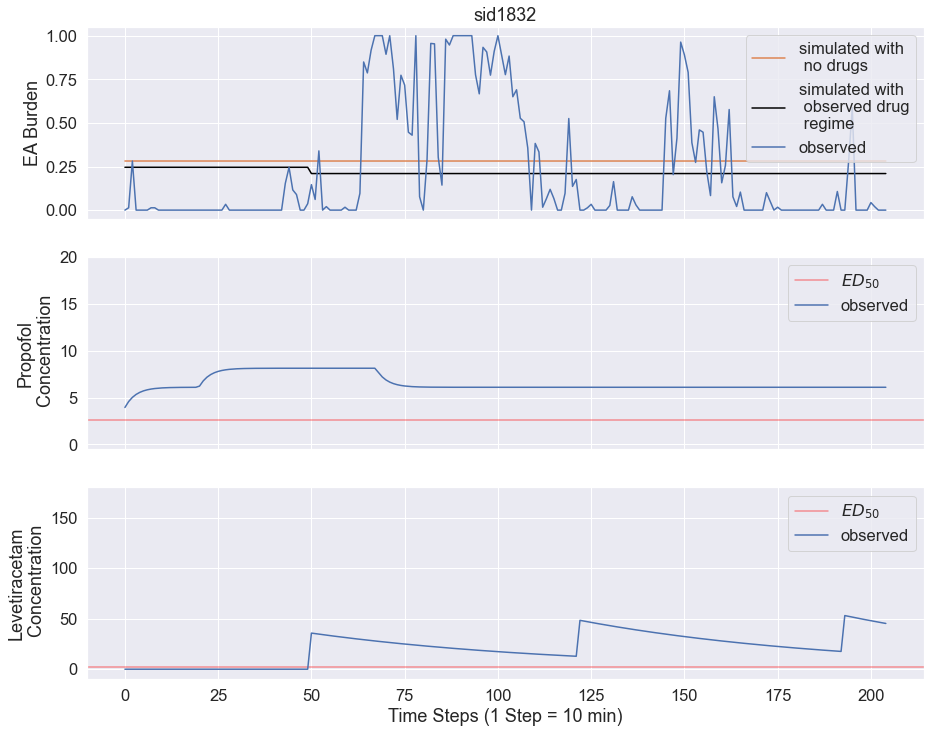

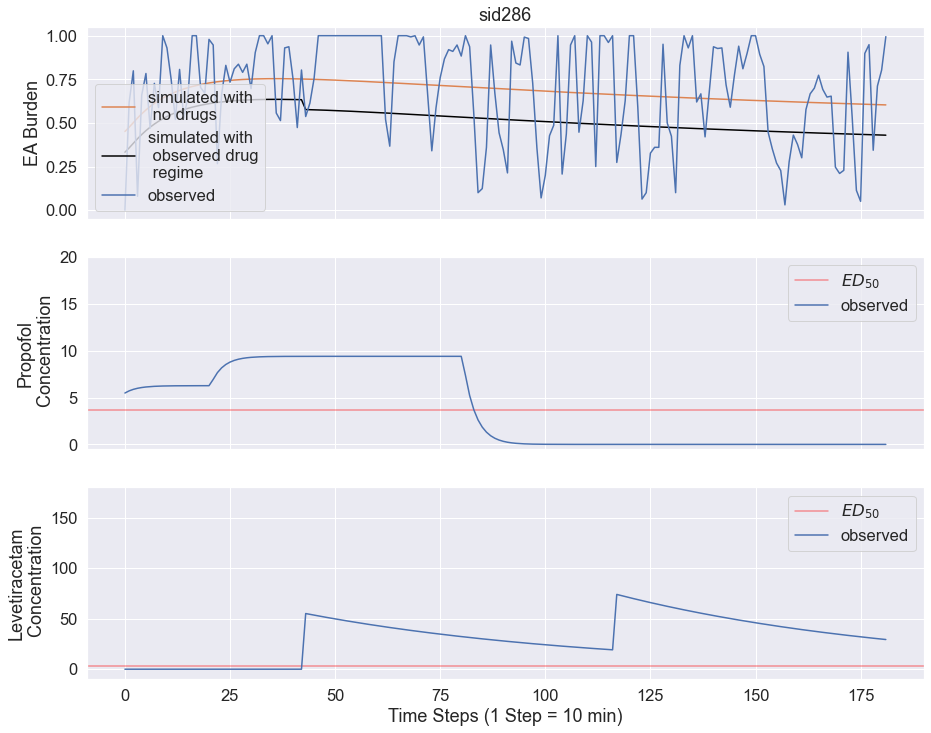

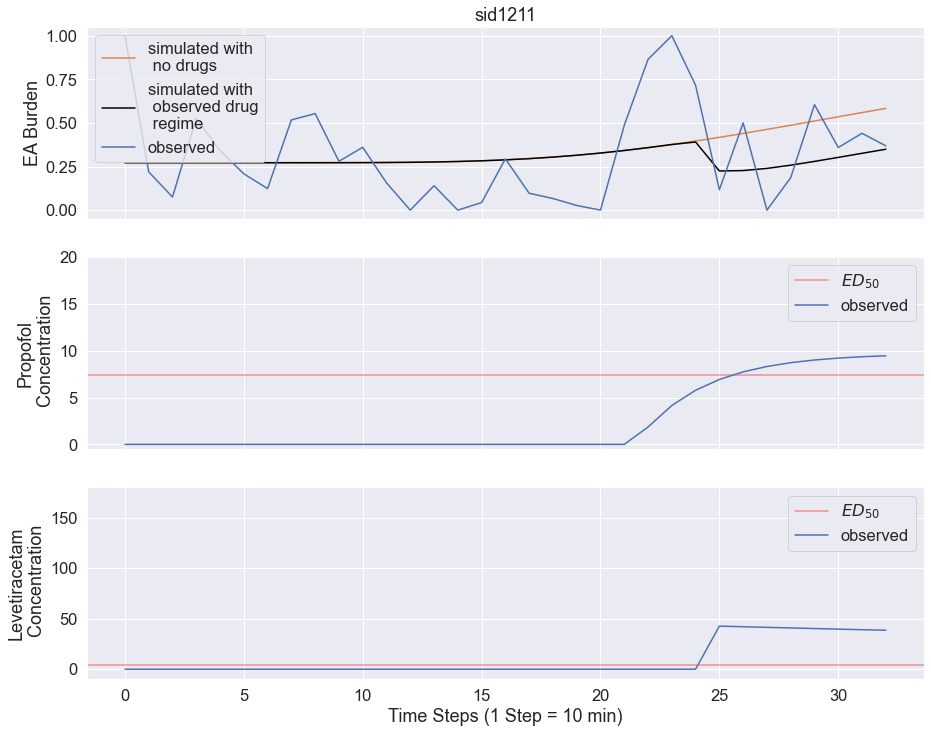

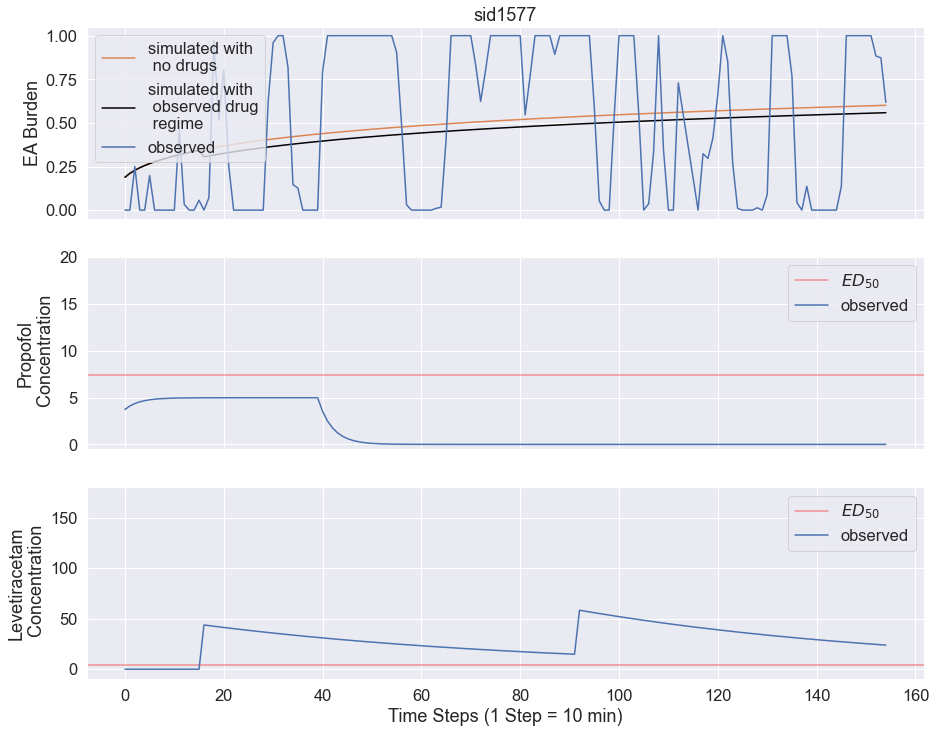

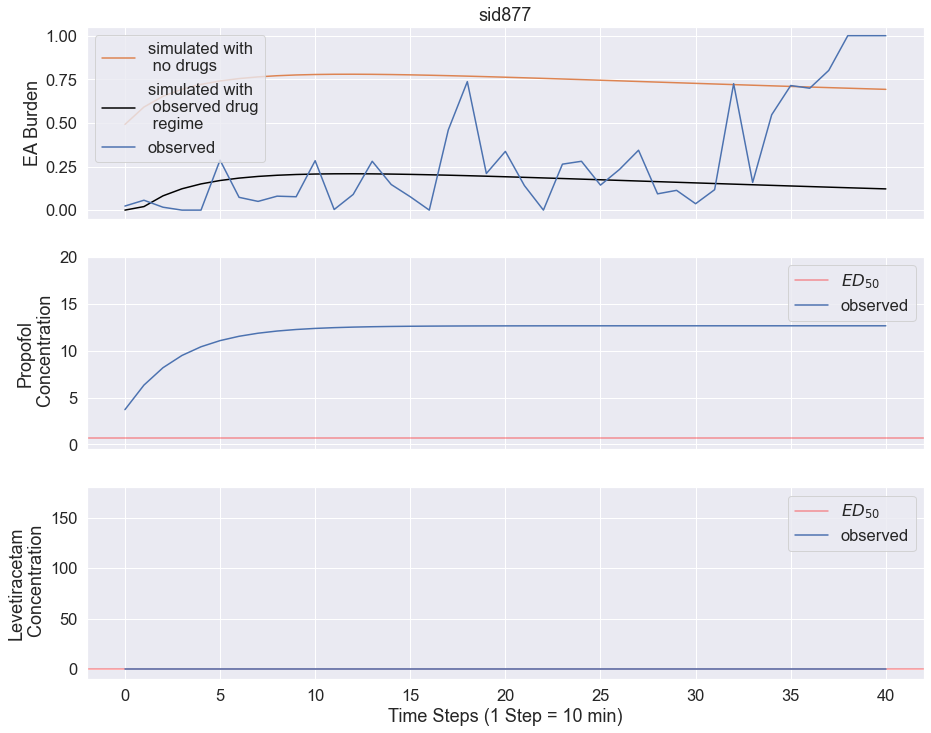

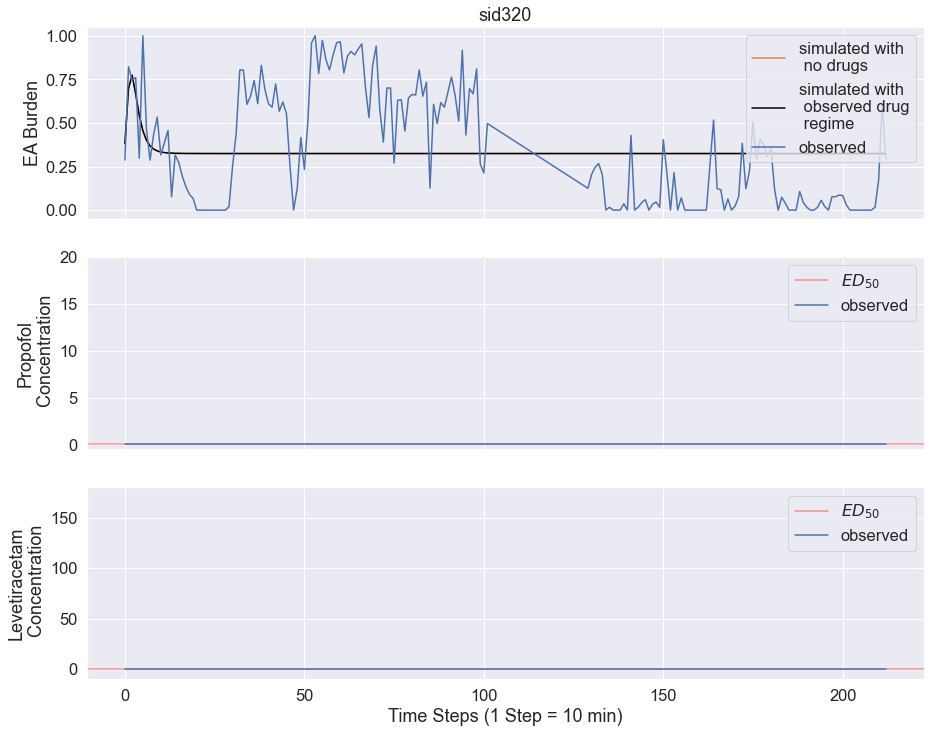

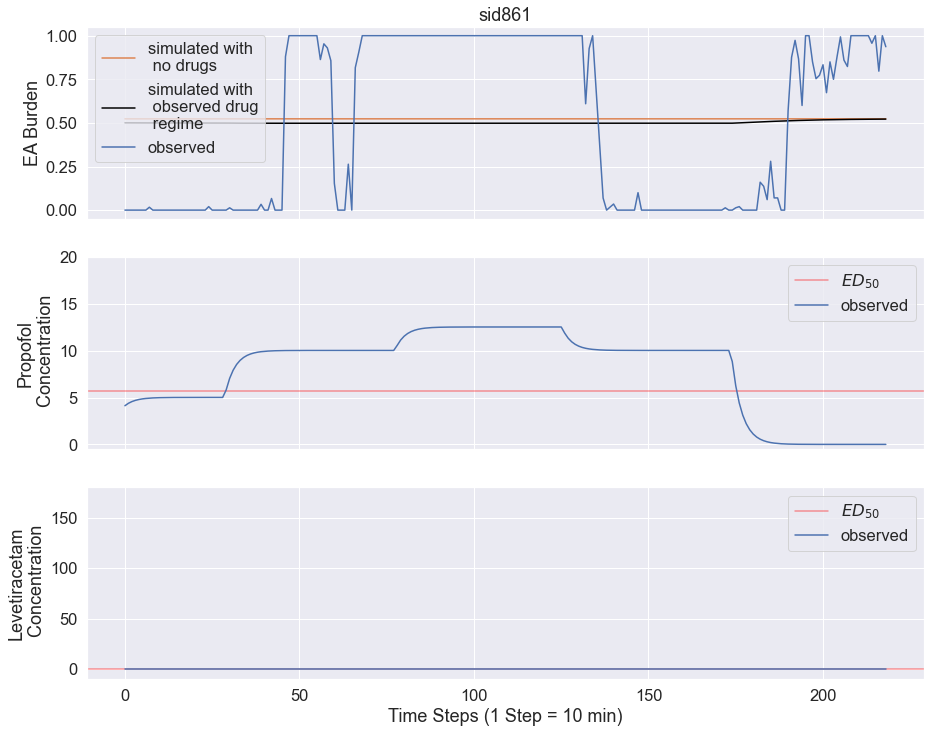

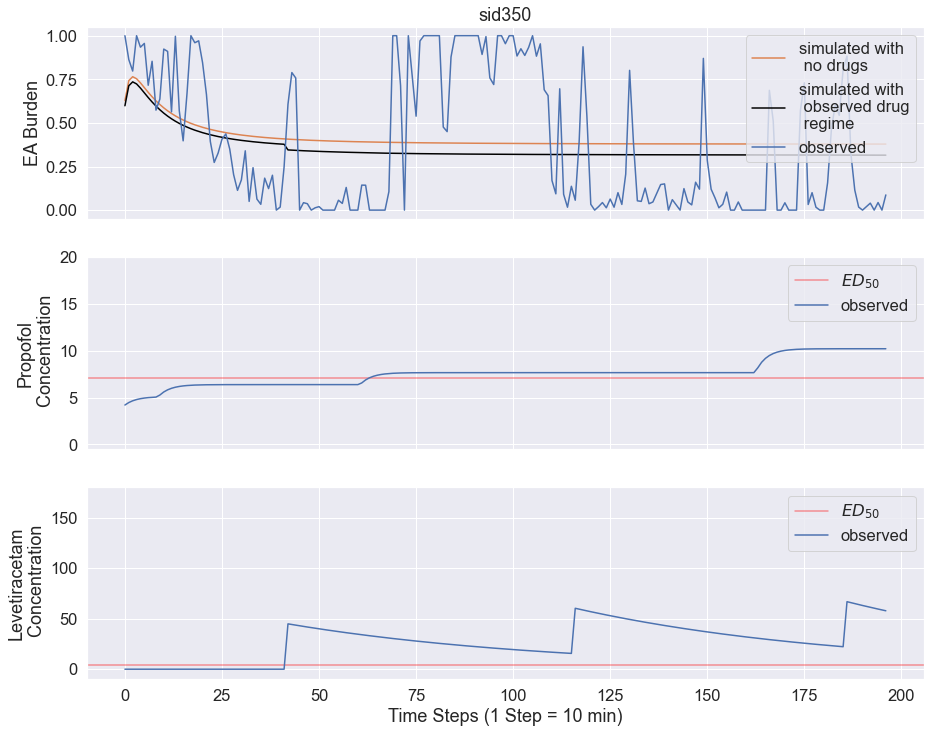

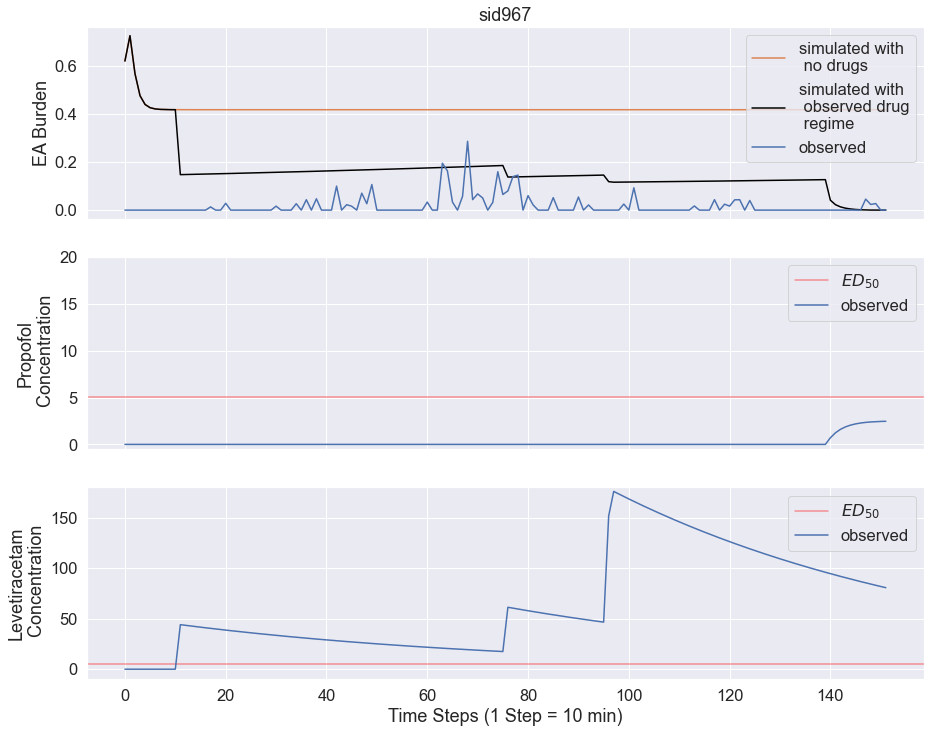

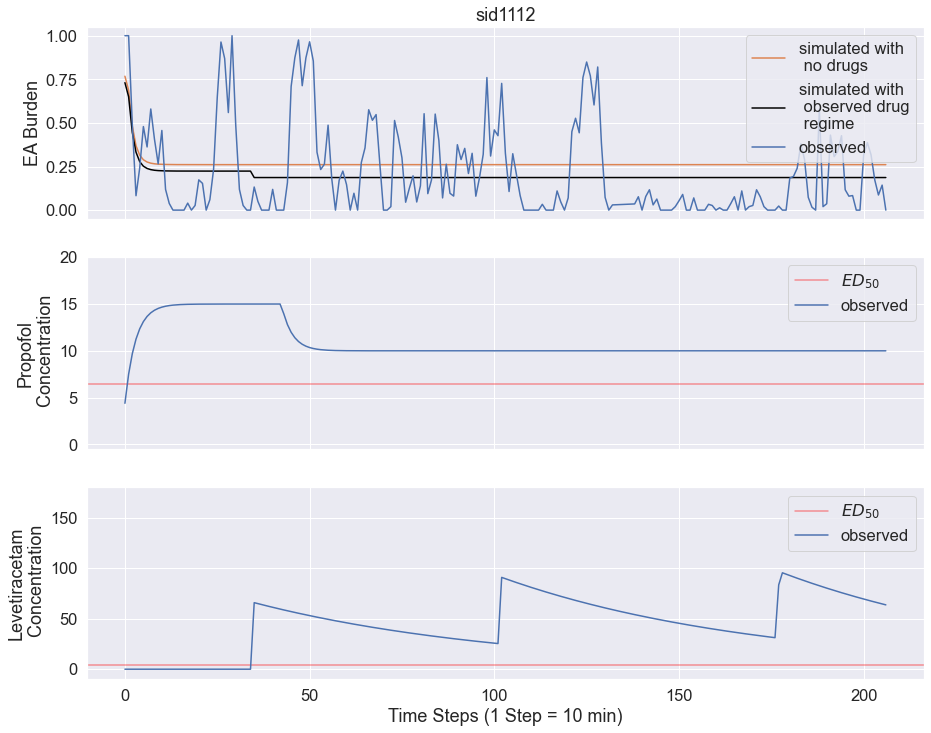

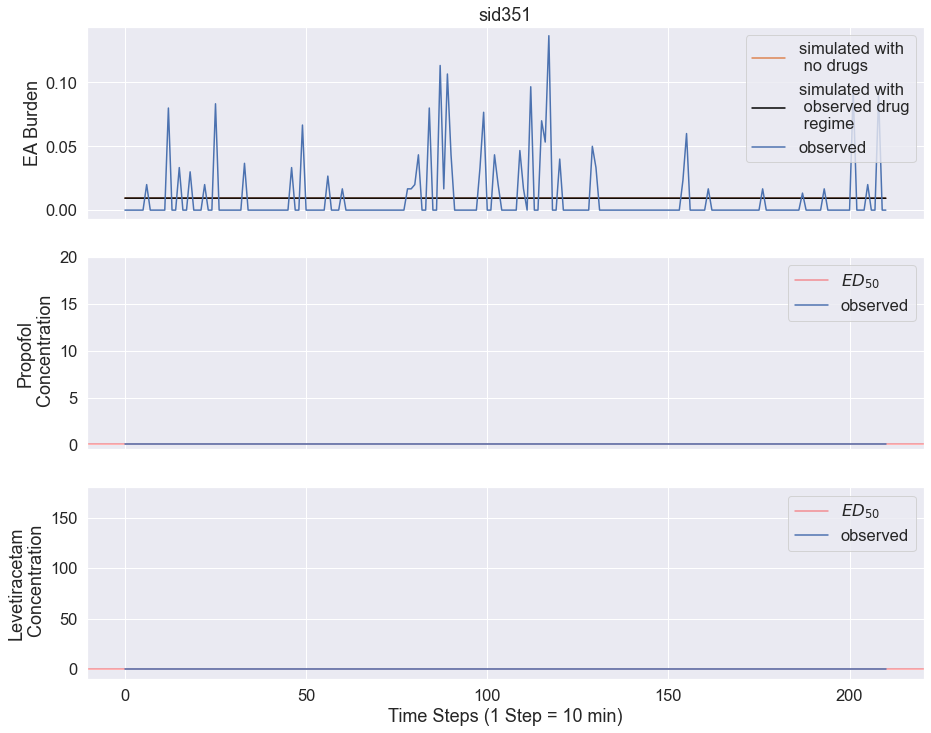

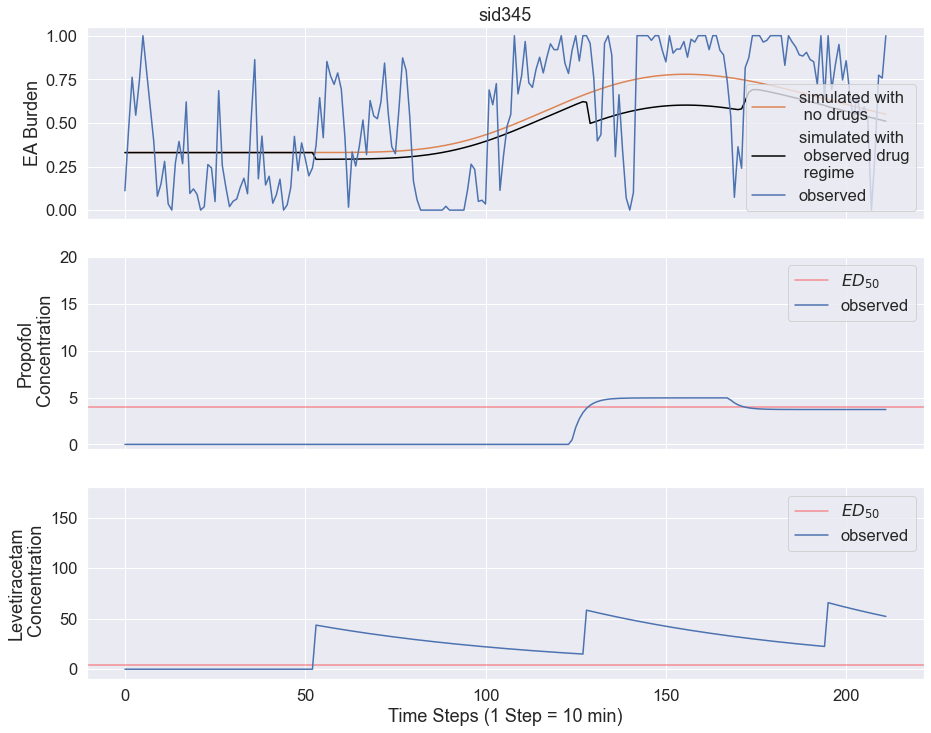

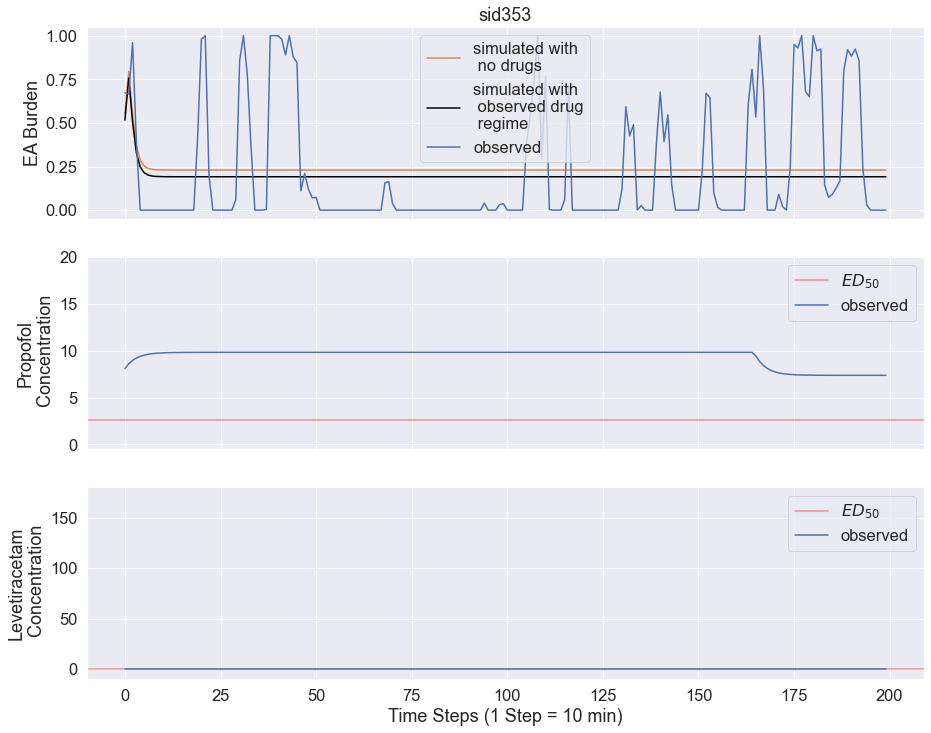

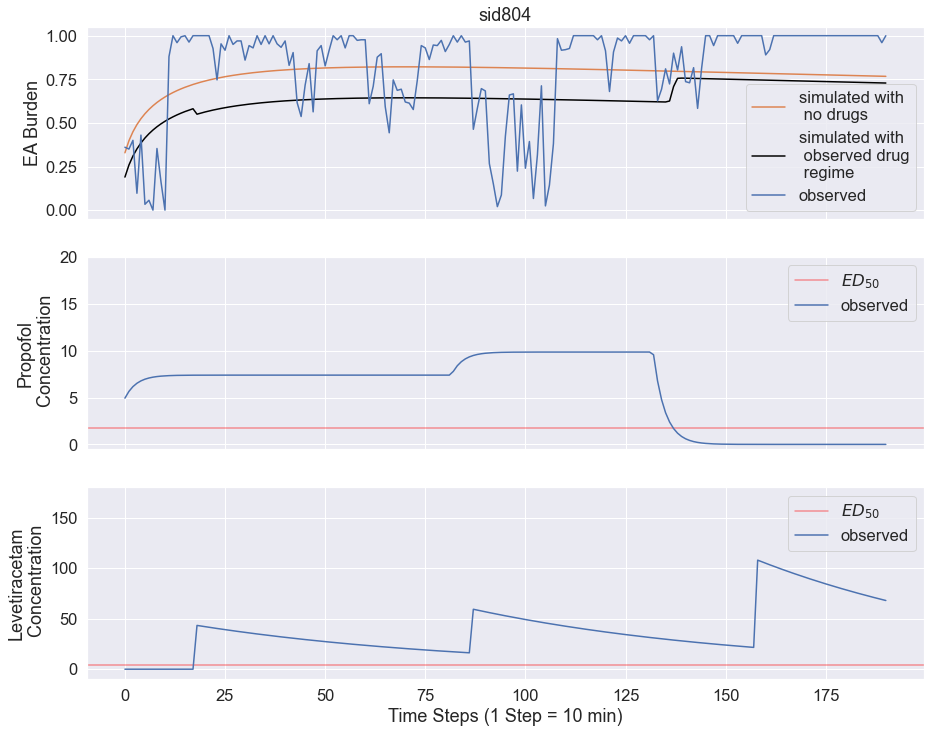

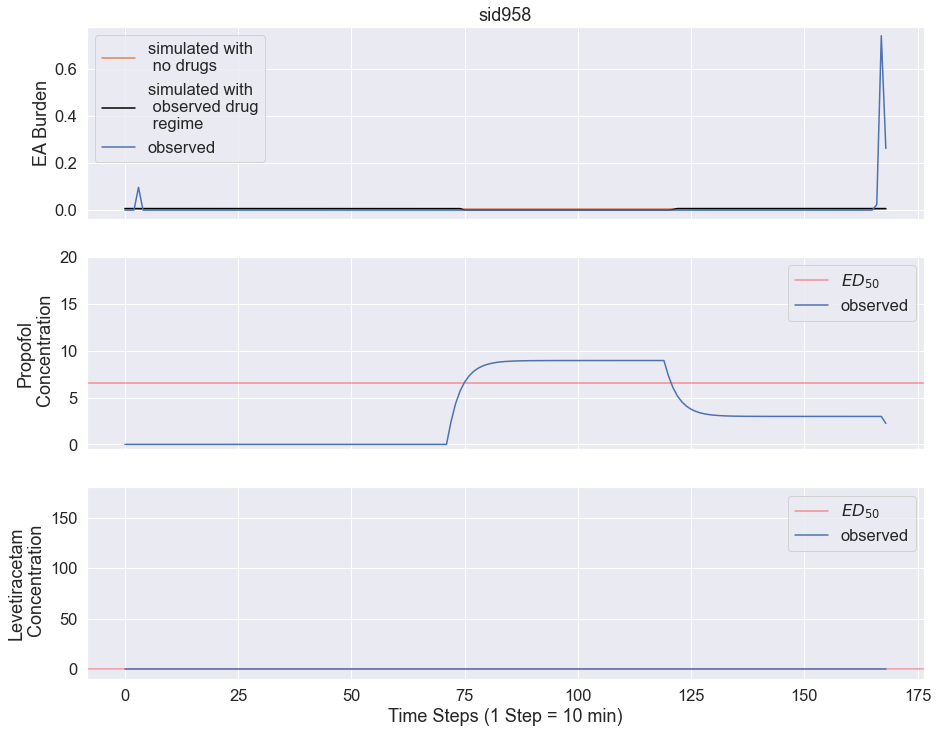

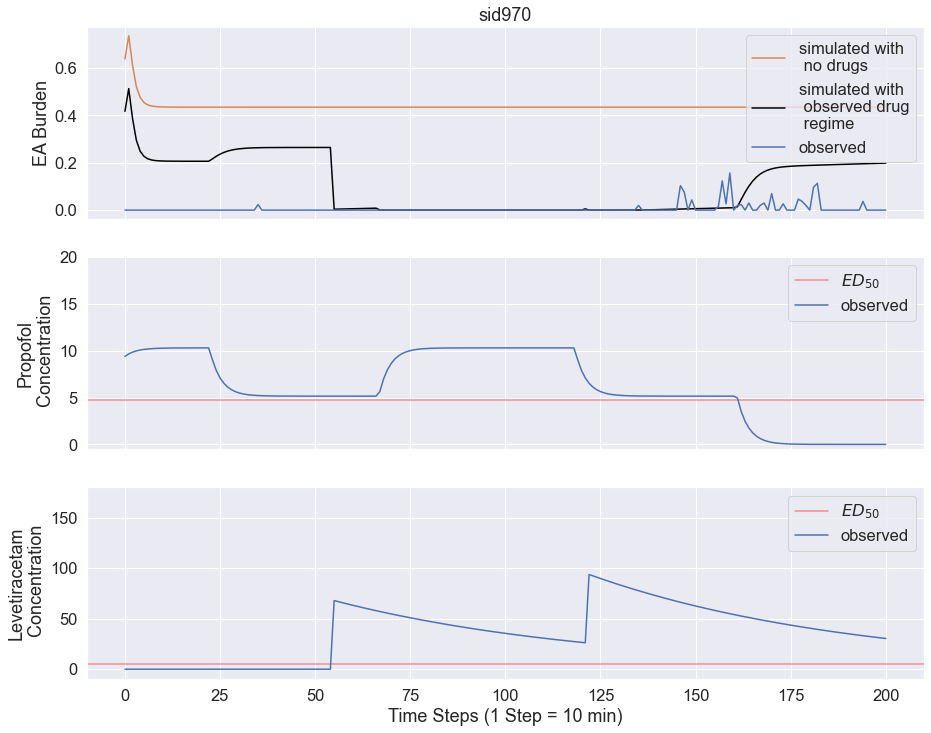

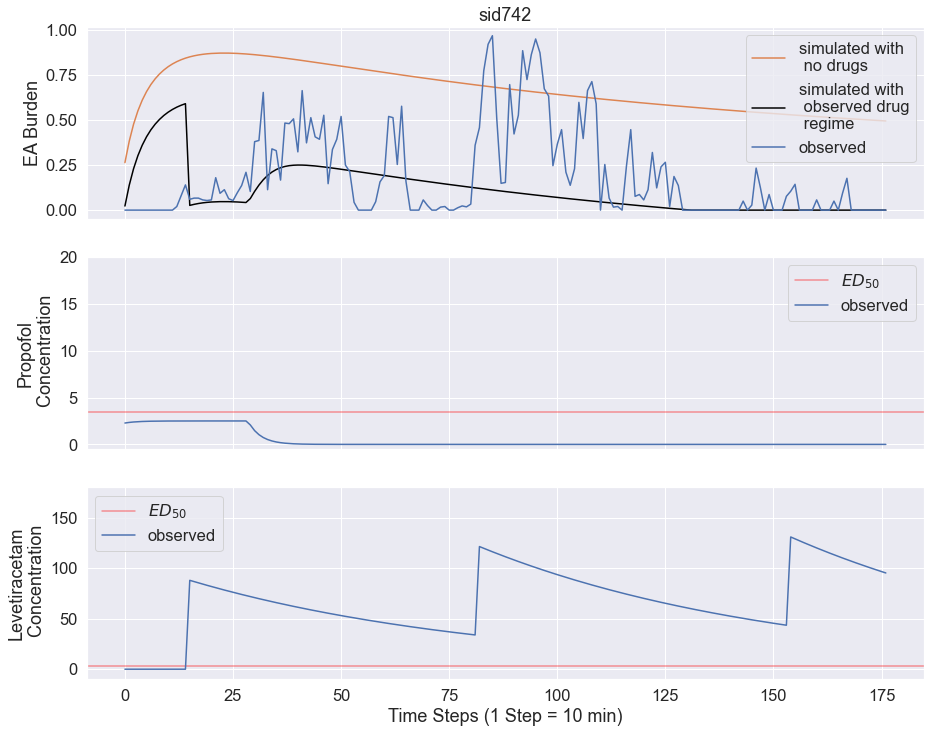

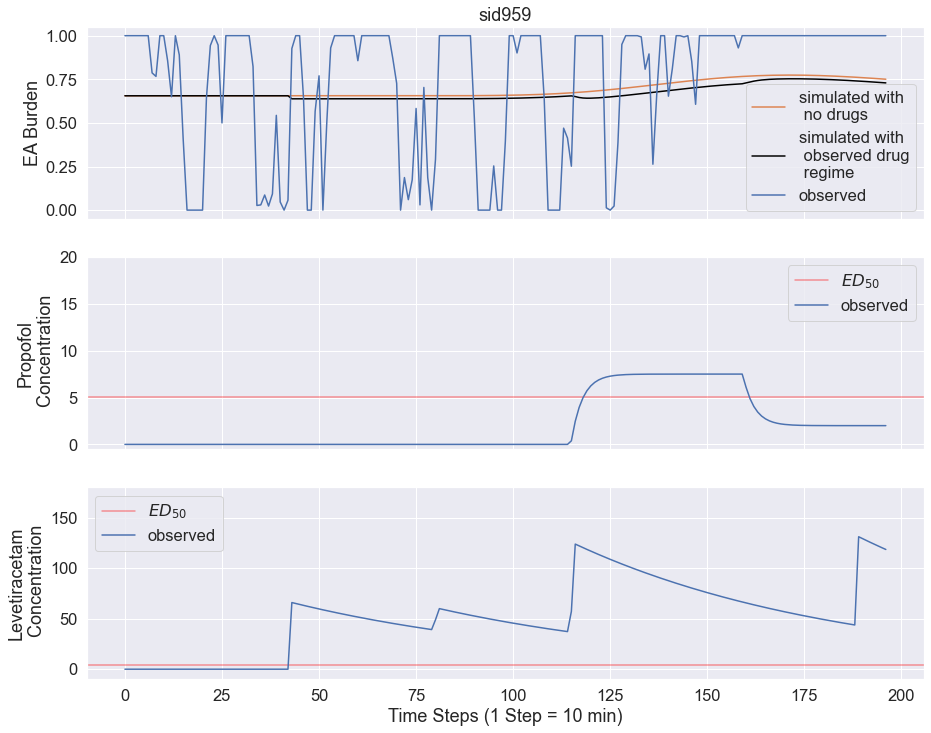

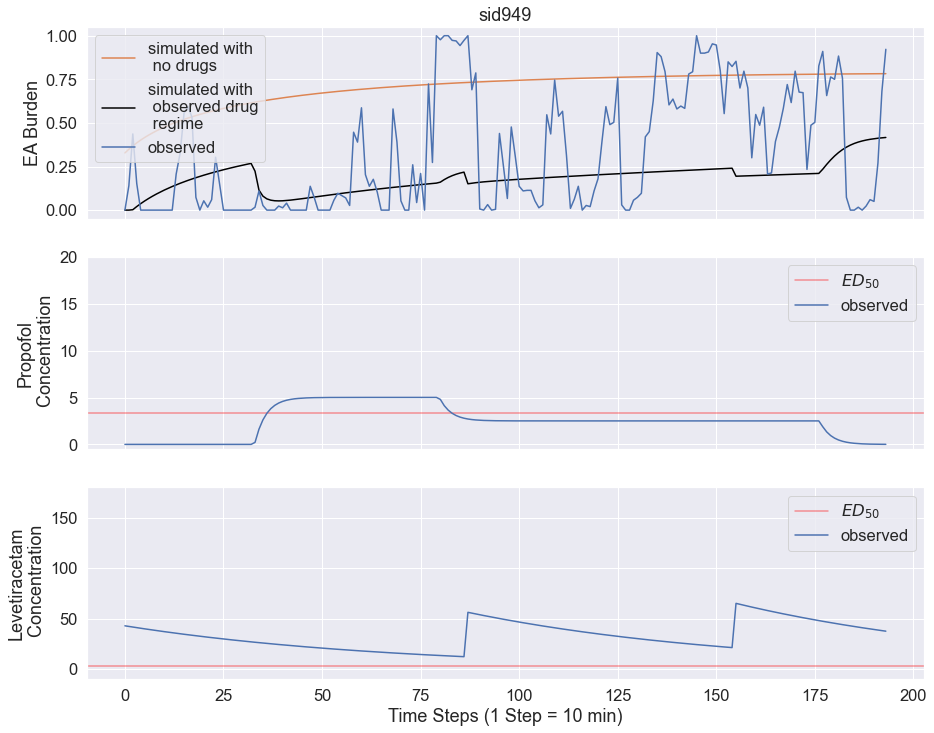

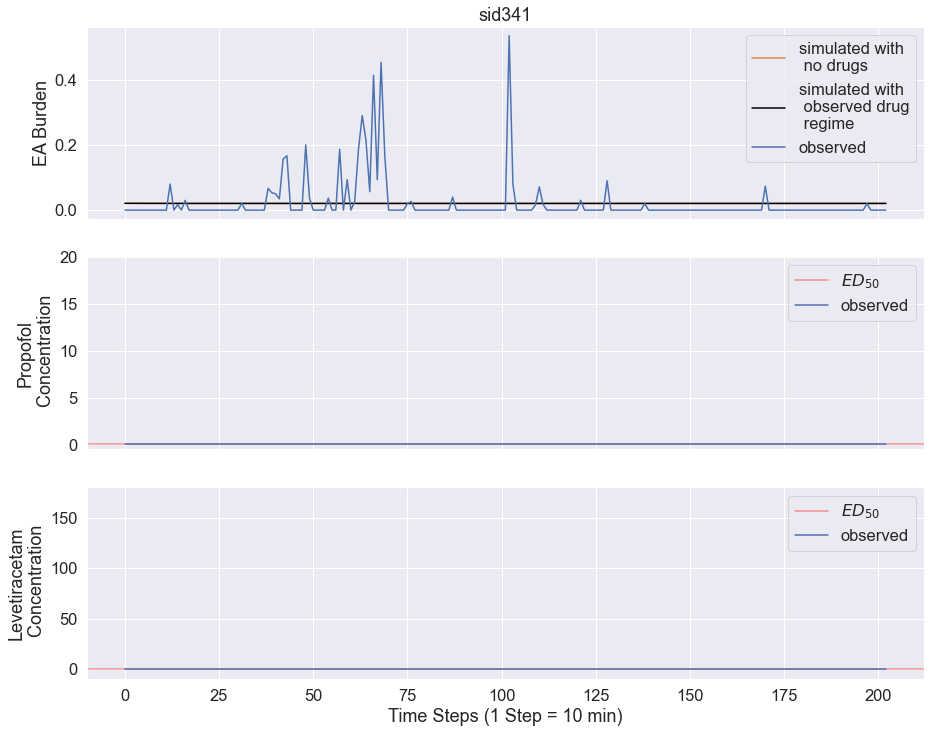

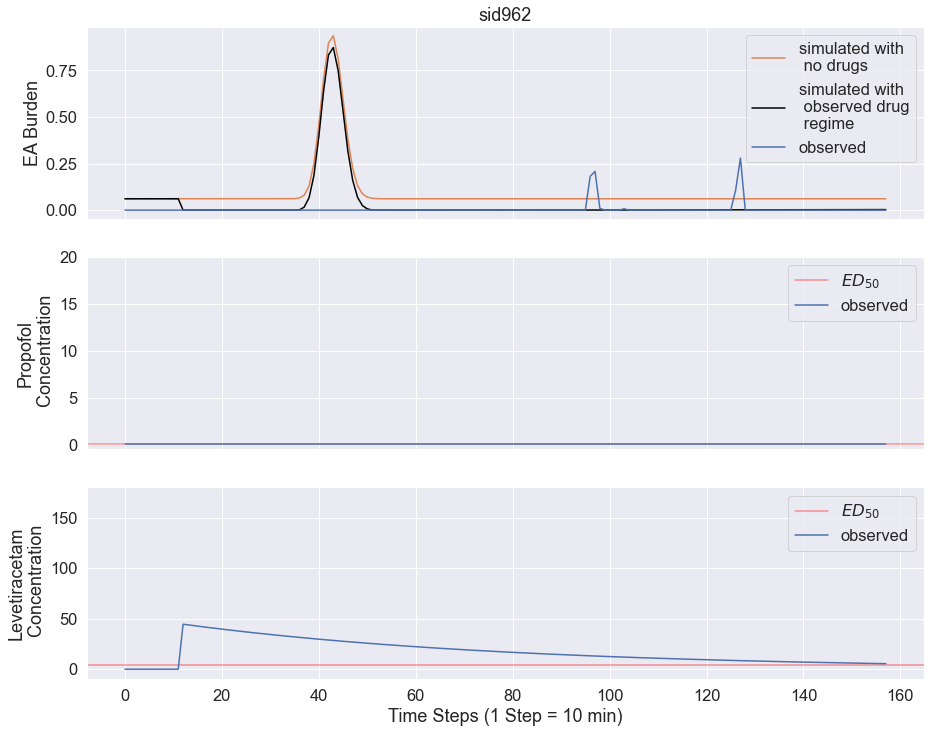

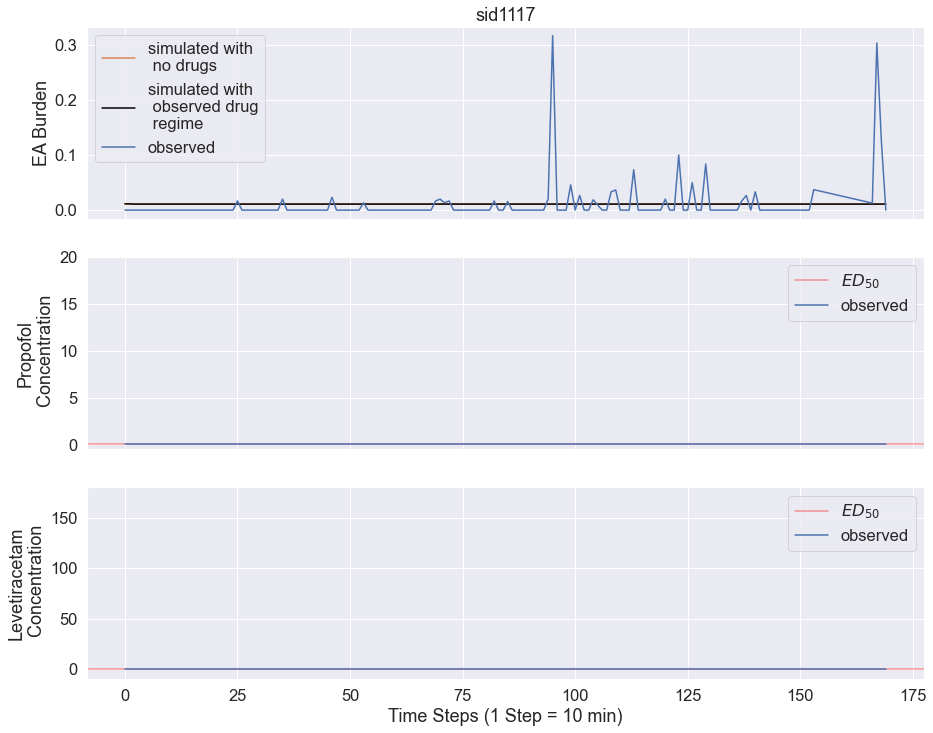

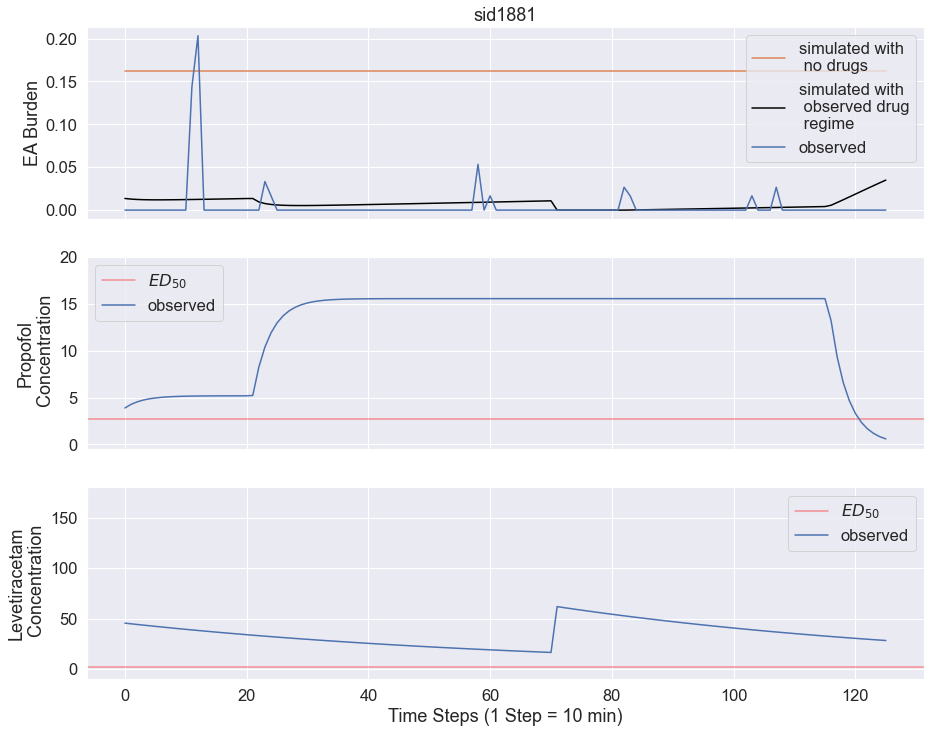

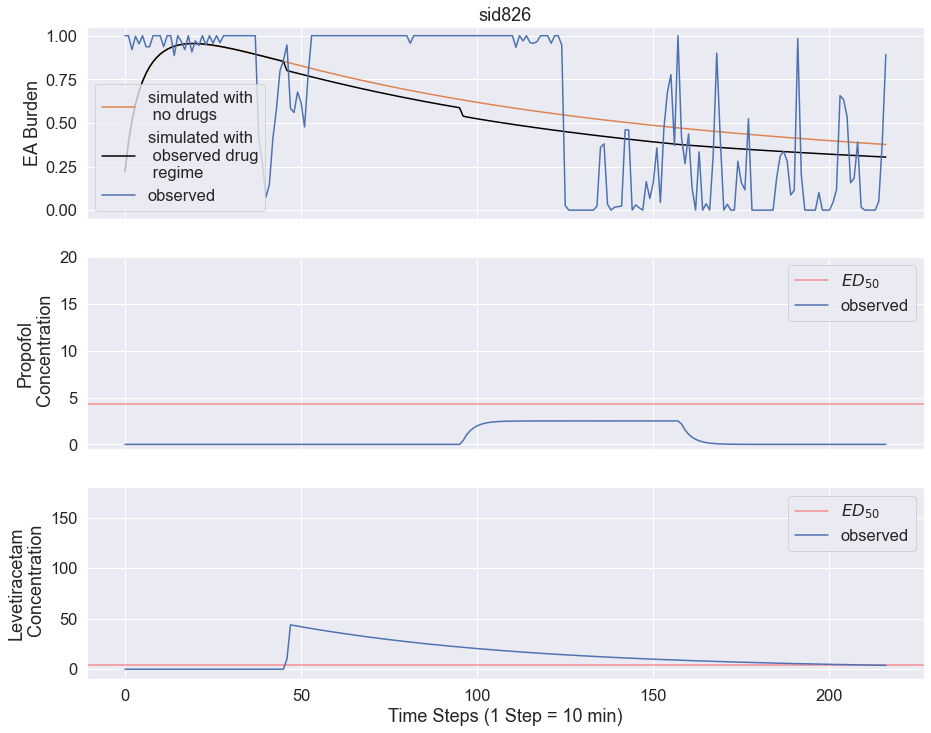

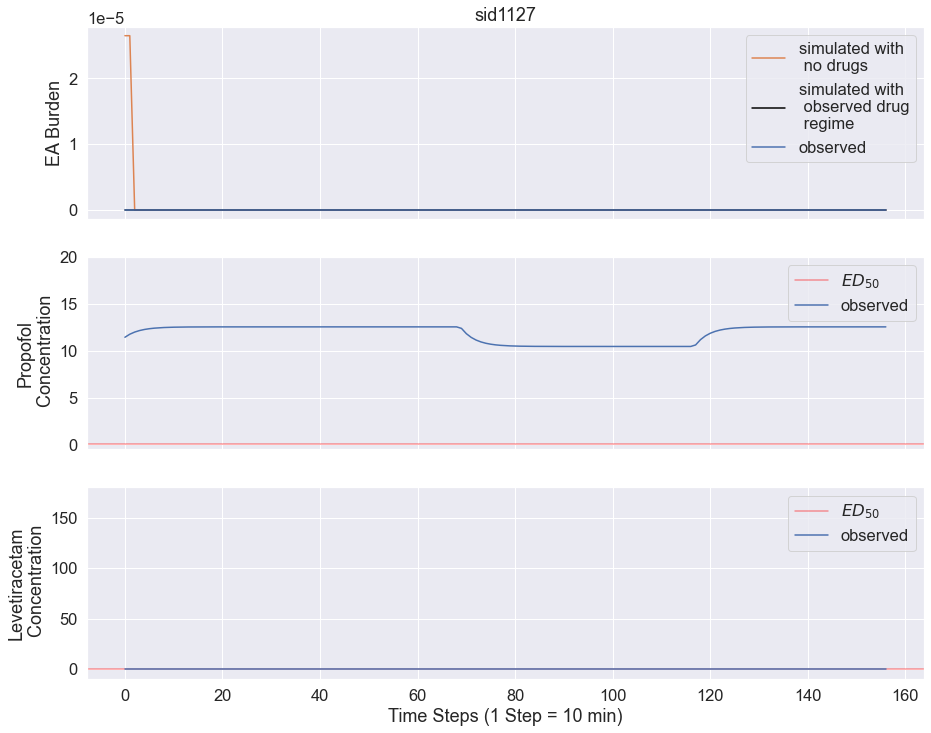

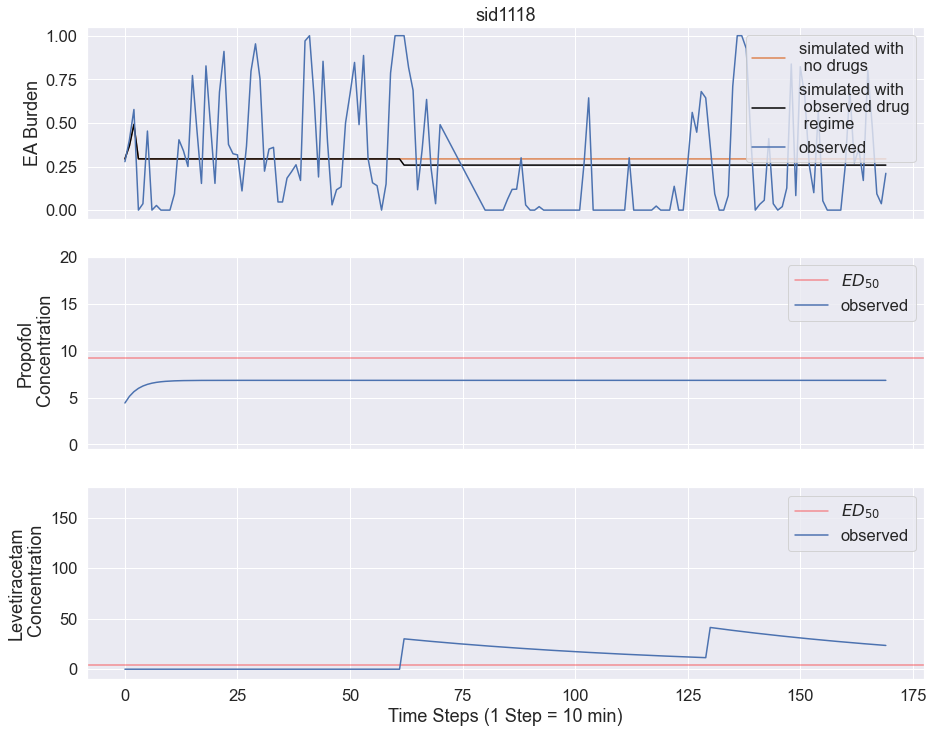

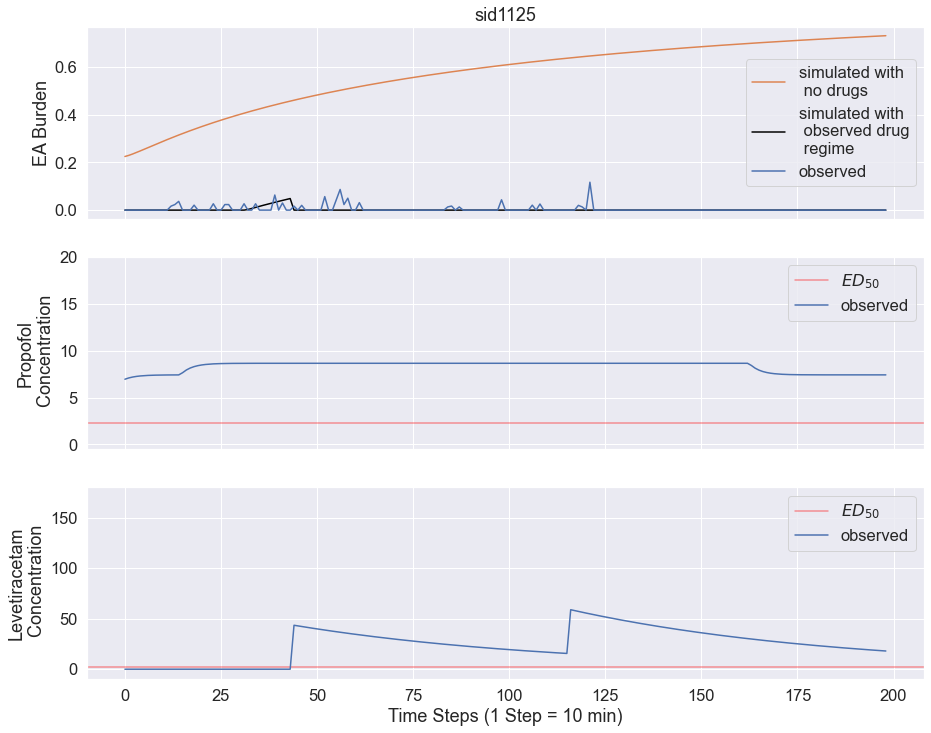

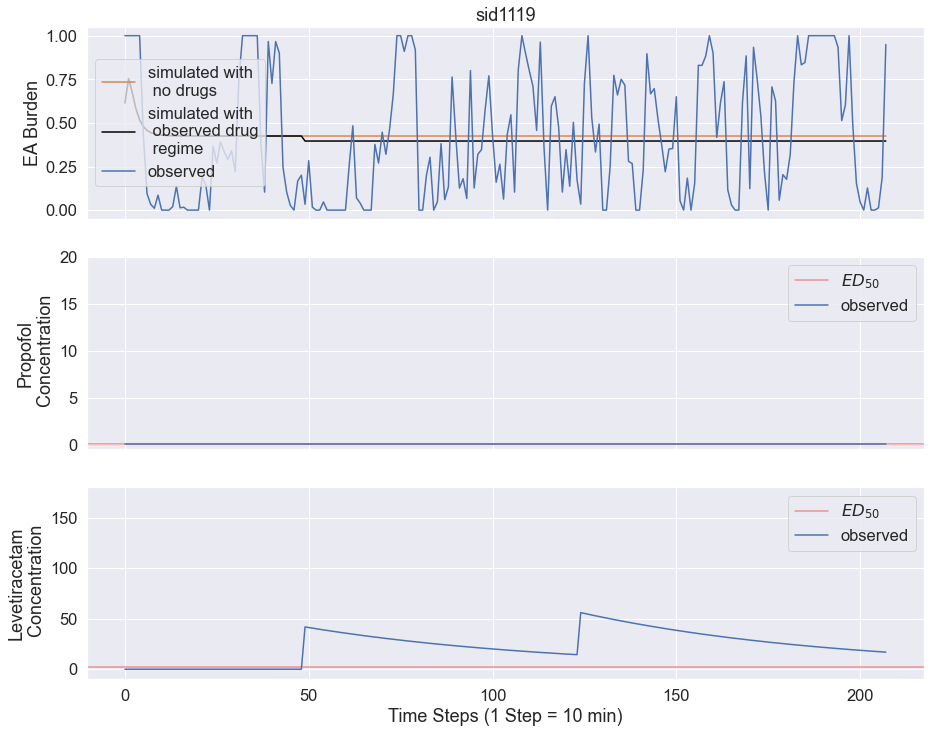

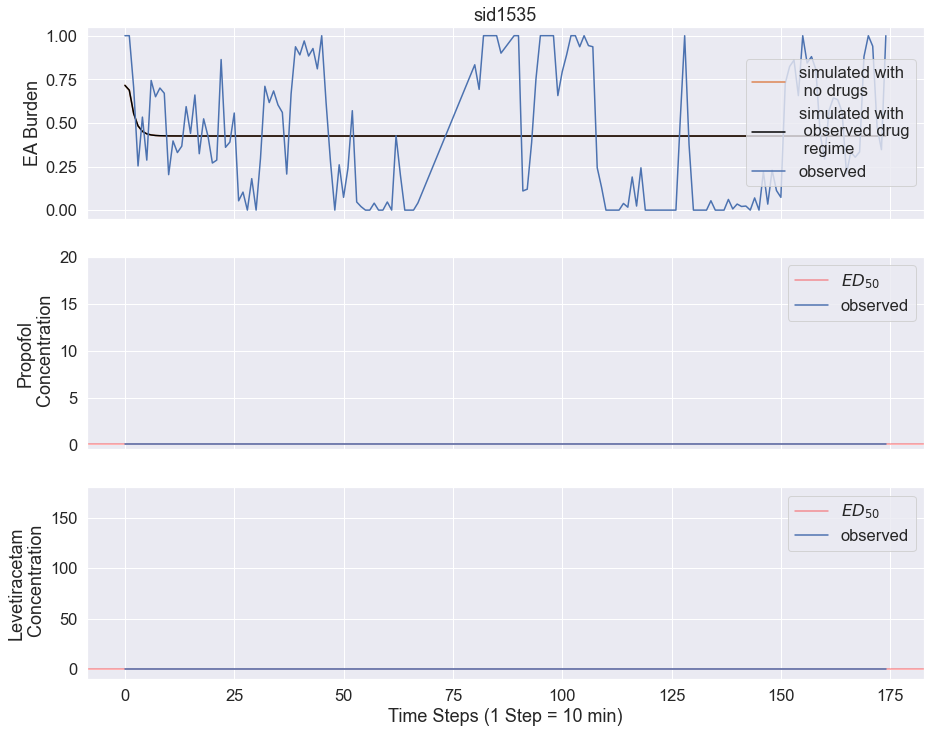

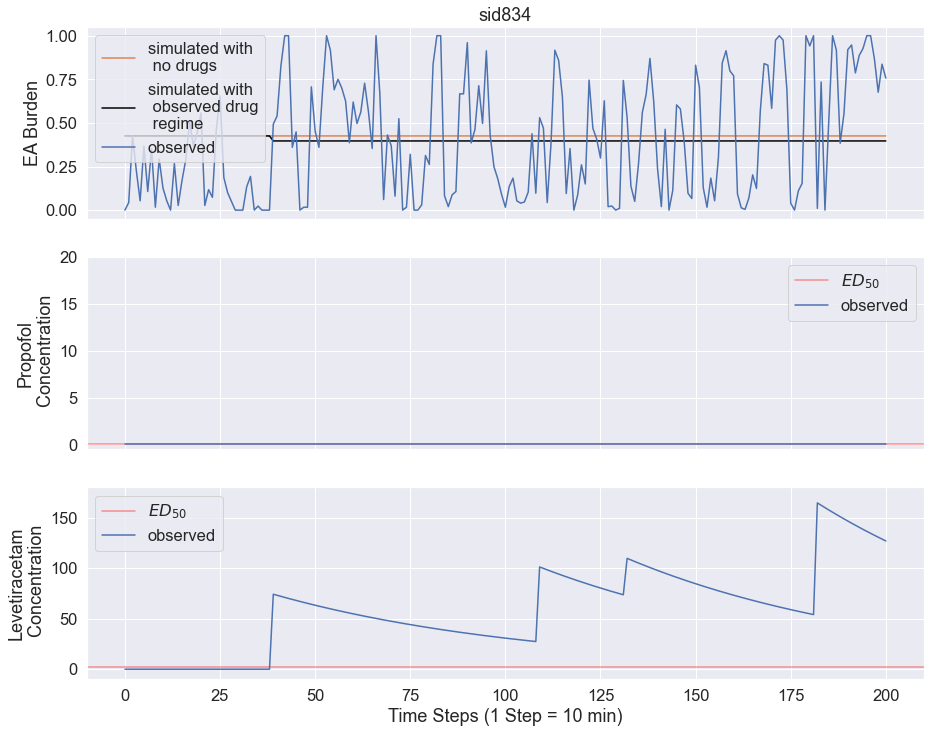

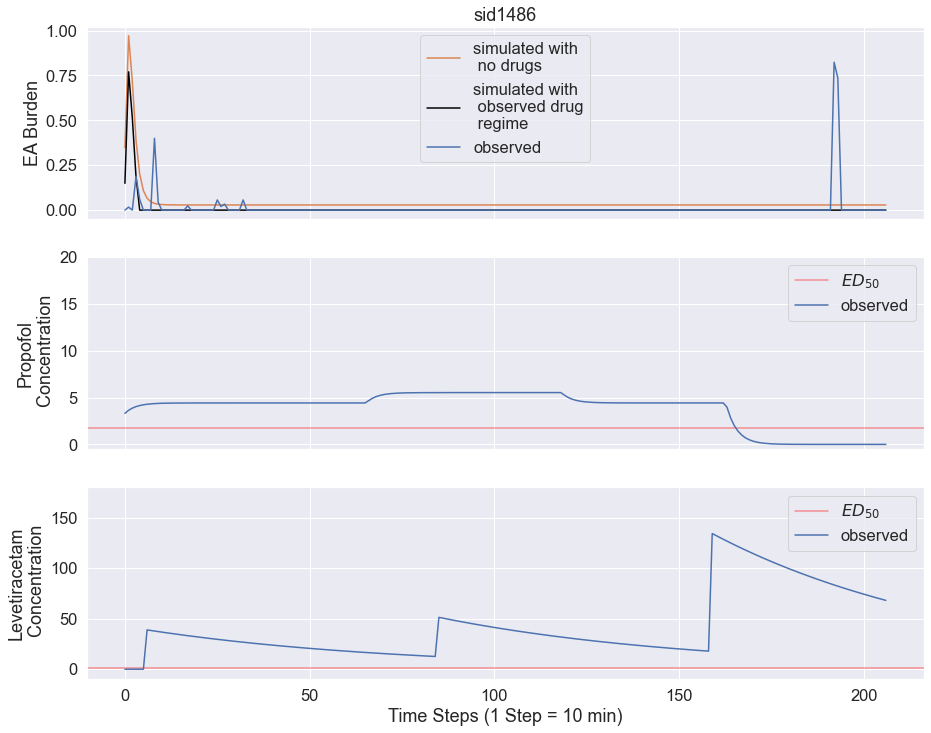

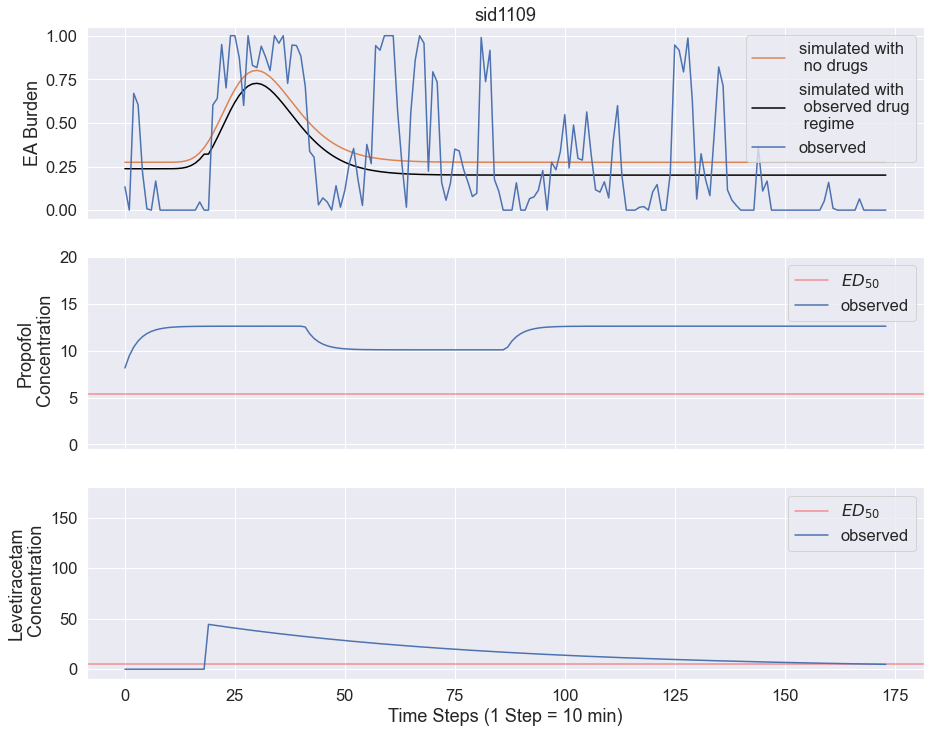

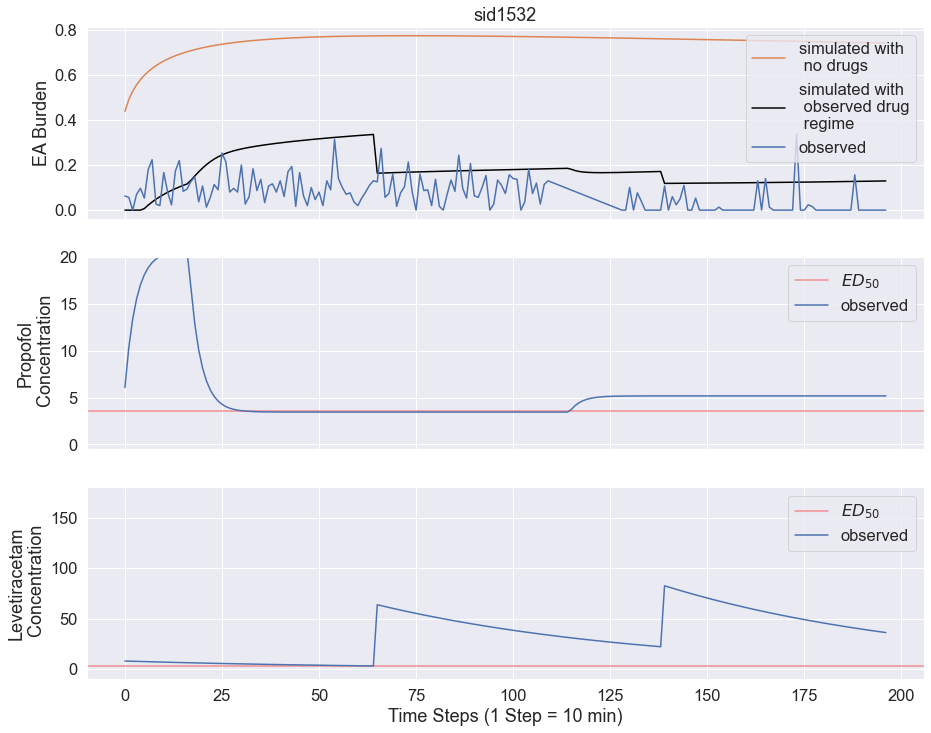

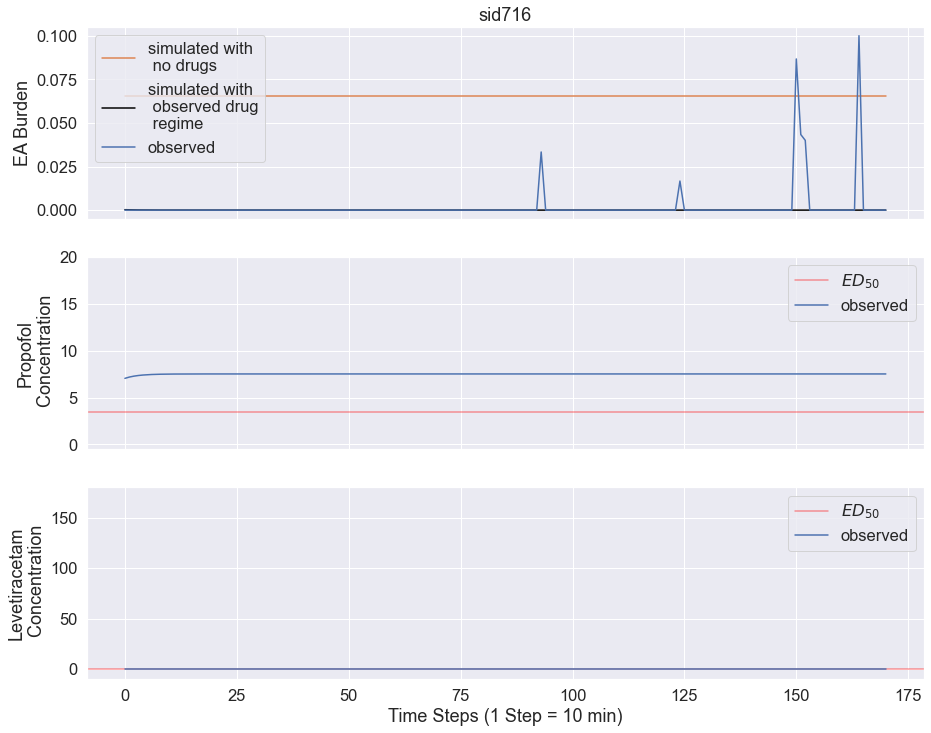

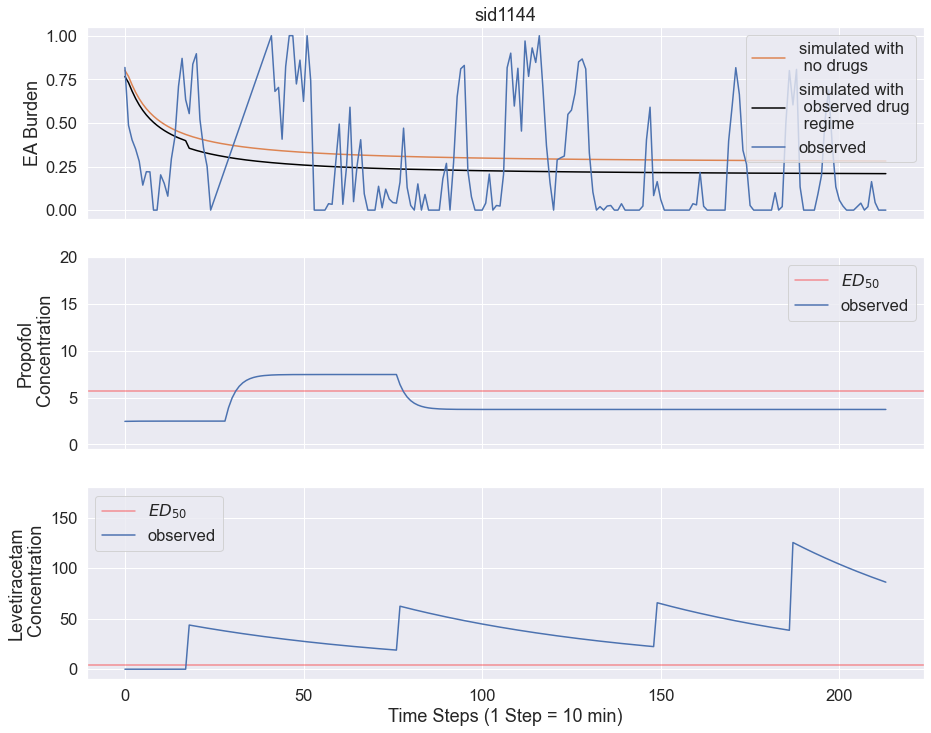

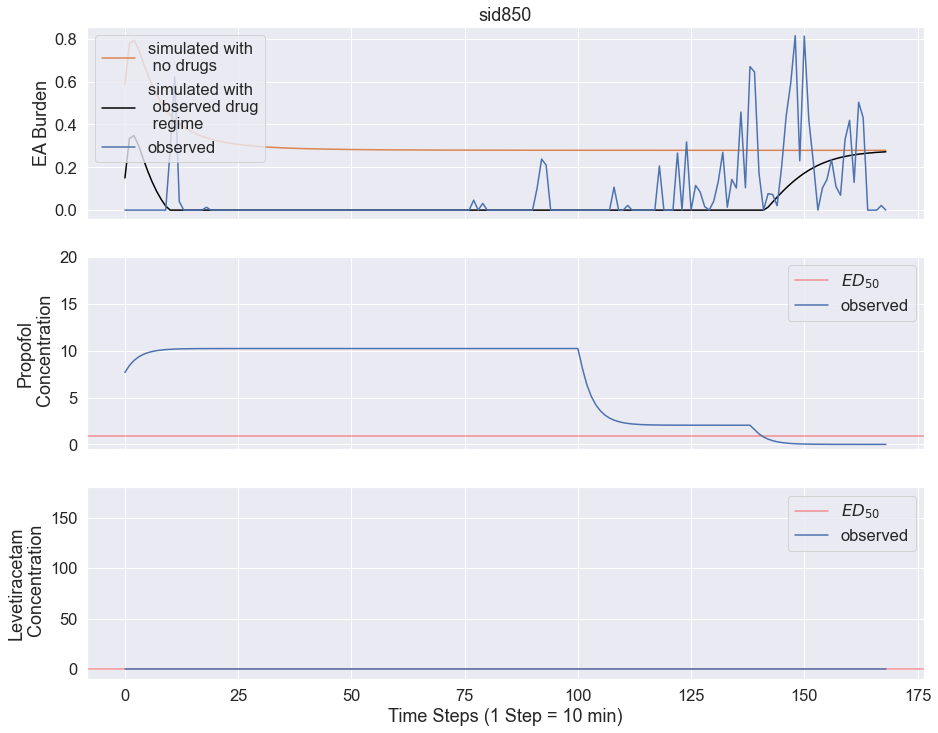

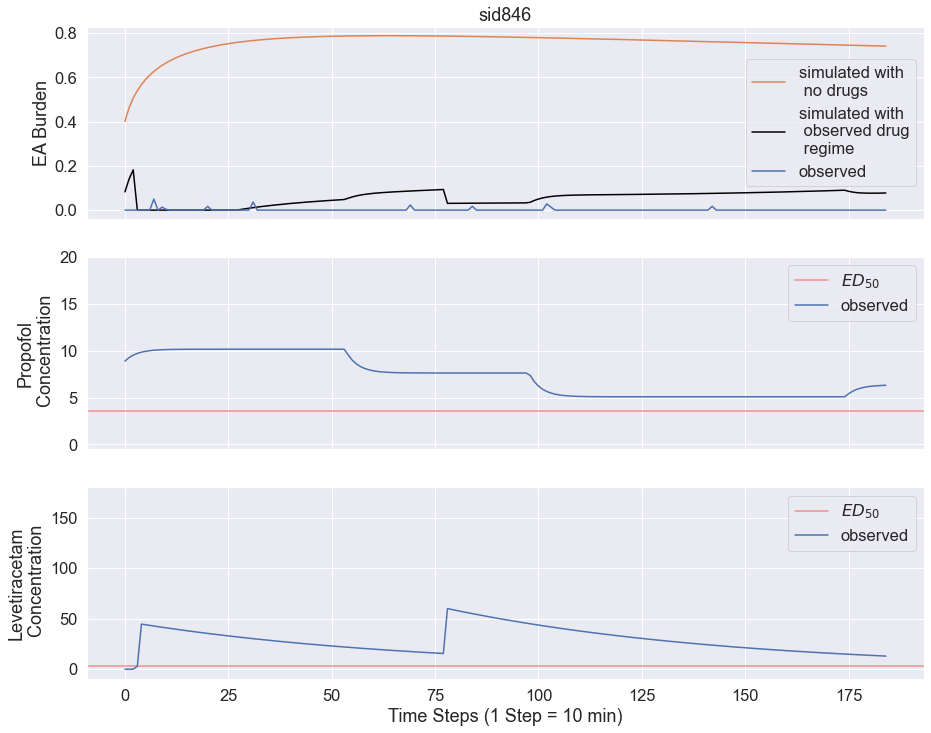

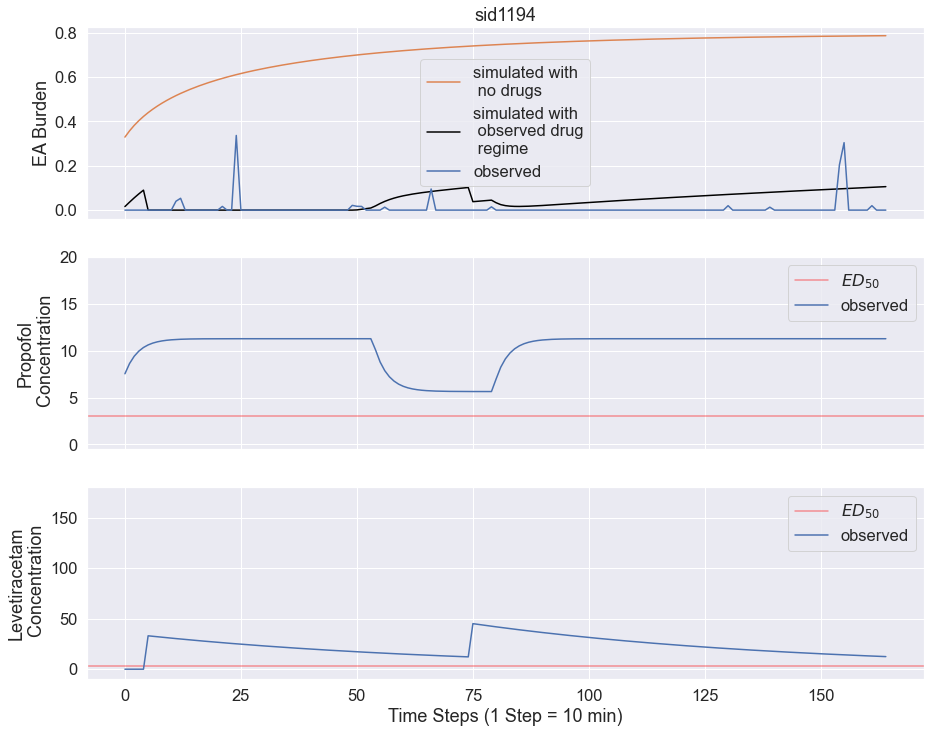

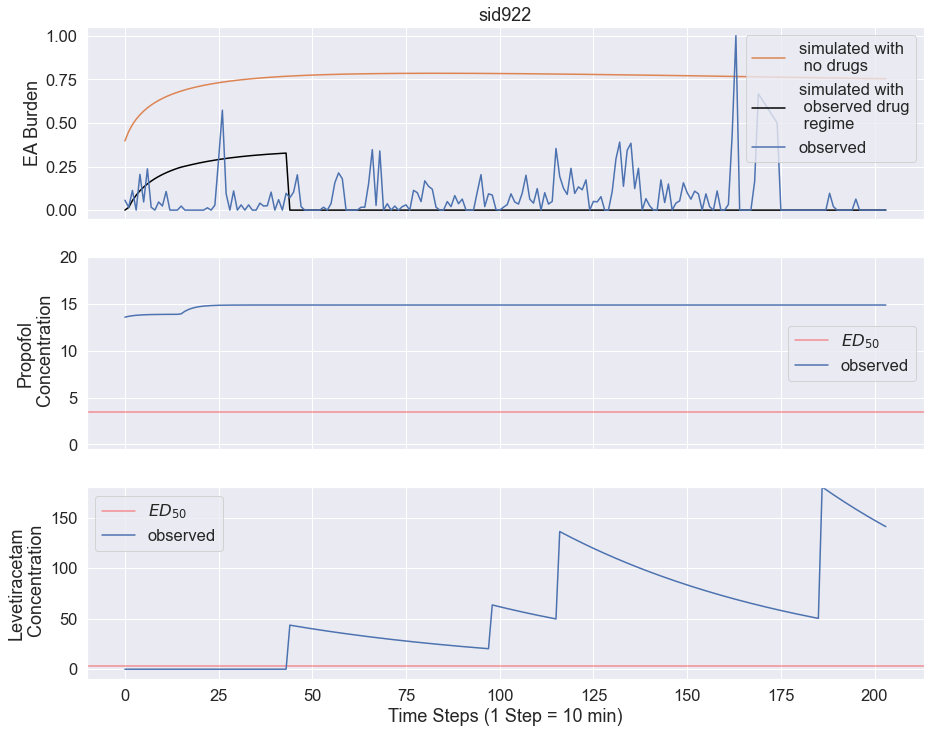

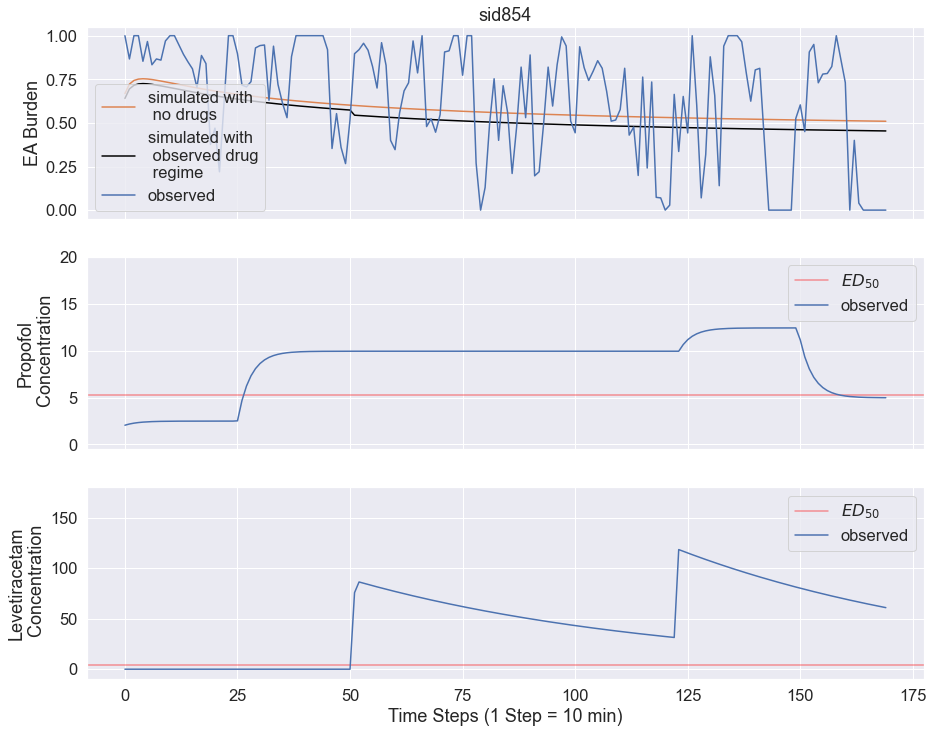

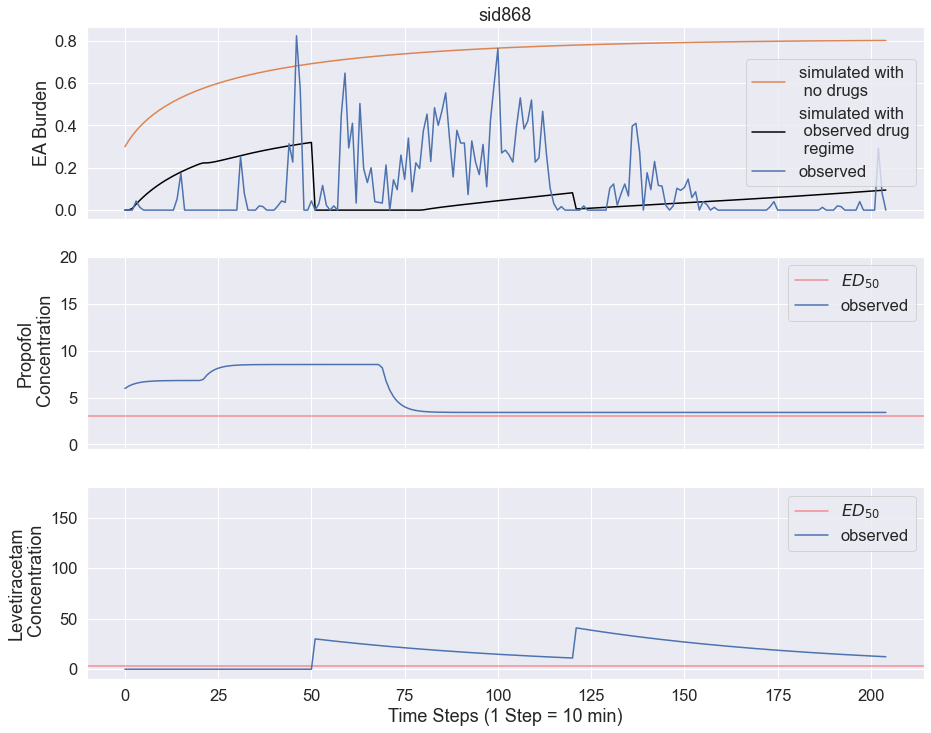

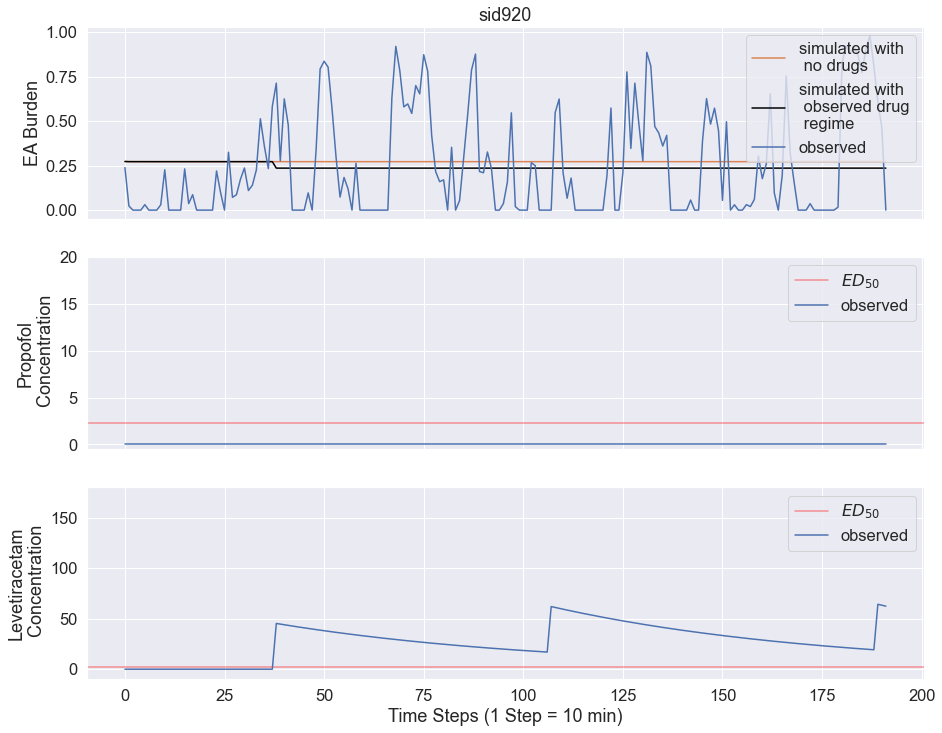

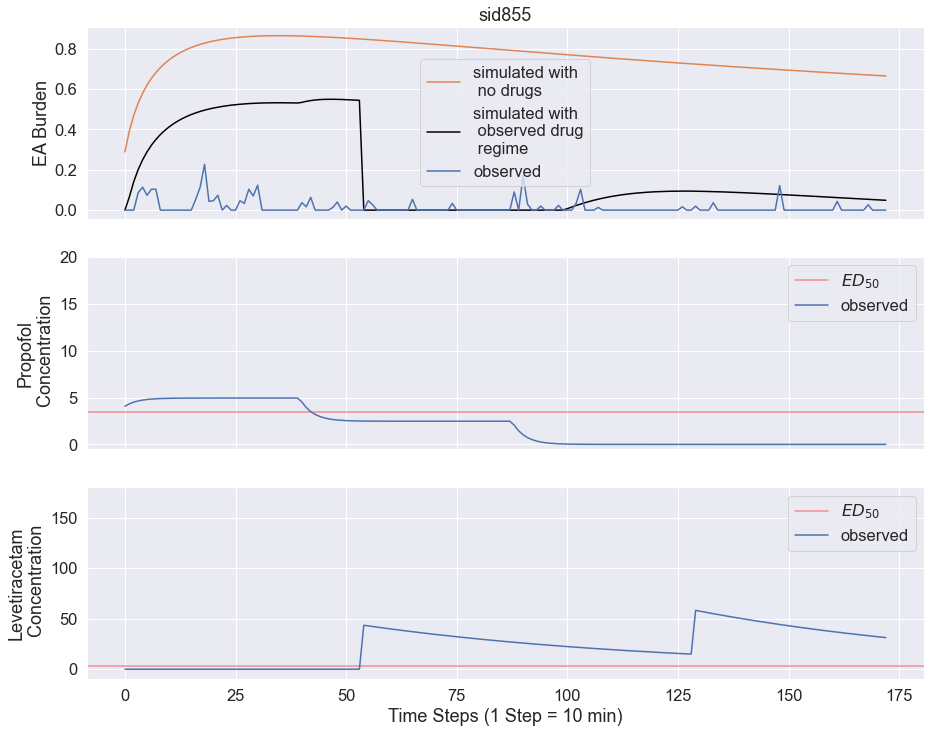

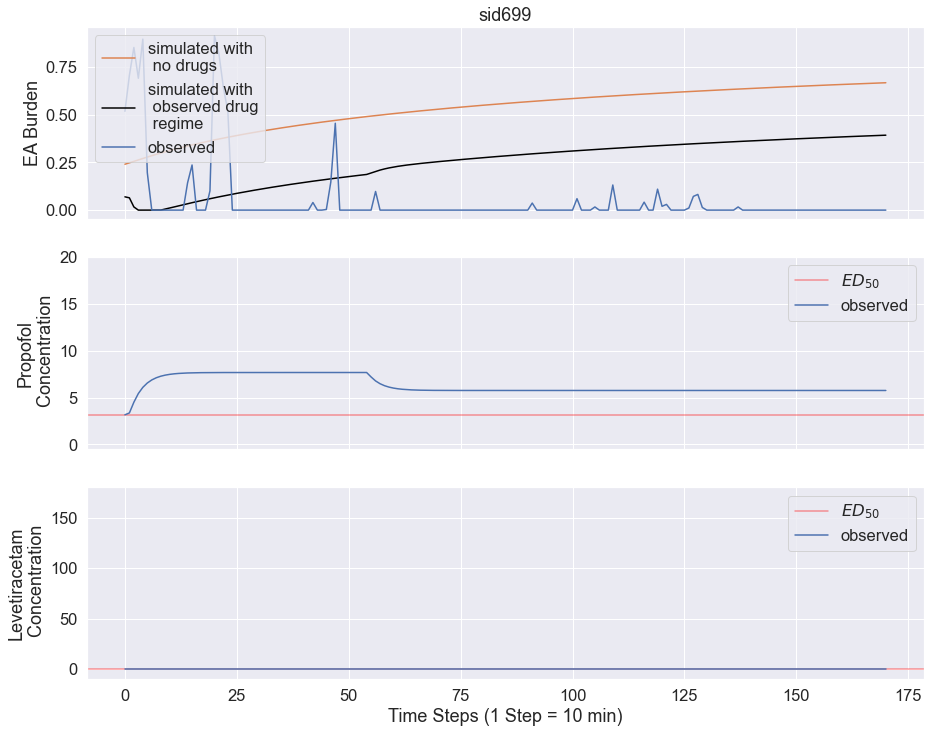

In [393]:
for j in range(len(patients_idx)):
    sns.set(font_scale=1.5)

    i = patients_idx[j]
    D = iic_burden['D'][i]
    D = pd.DataFrame(D,columns=iic_burden['Dname'])[drugs_interest]
    E = pd.Series(iic_burden['Pobs'][i])
    E = E.interpolate(method='linear')

    E_sim = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                         D_=D.values,
                         Timesteps=iic_burden['D'][i].shape[0])
    E_sim0 = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                         D_=np.zeros_like(D.values),
                         Timesteps=iic_burden['D'][i].shape[0])

    fig,ax = plt.subplots(nrows=3,figsize=(15,12),sharex=True)


    ax[0].plot(E_sim0,c='C1')
    ax[0].plot(E_sim,c='black')
    ax[0].plot(E)
    ax[0].legend(['simulated with\n no drugs','simulated with\n observed drug\n regime','observed'])
    ax[0].set_ylabel('EA Burden')
    ax[0].set_title(patients[j])

    ax[1].axhline(pd_param_df['propofol_50'].iloc[j],c='red',alpha=0.4)
    ax[1].plot(D['propofol'])
    ax[1].legend([r'$ED_{50}$','observed'])
    ax[1].set_ylabel('Propofol\n Concentration')
    ax[1].set_ylim((-0.5,20))

    ax[2].axhline(pd_param_df['levetiracetam_50'].iloc[j],c='red',alpha=0.4)
    ax[2].plot(D['levetiracetam'])
    ax[2].set_ylabel('Levetiracetam\n Concentration')
    ax[2].set_ylim((-10,180))
    ax[2].legend([r'$ED_{50}$','observed'])
    ax[2].set_xlabel('Time Steps (1 Step = 10 min)')

    plt.savefig('/Users/harshparikh/Documents/RCT_sim_code/HillPD_Figures/'+patients[j]+'_Hill_PD_w_lognormal_baseline.png')

<AxesSubplot:ylabel='Density'>

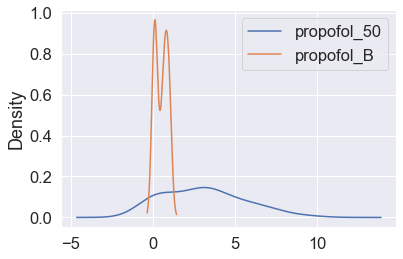

In [394]:
pd_param_df[['propofol_50','propofol_B']].plot(kind='kde')

In [395]:
pd_param_df.round(4)

levetiracetam_50  levetiracetam_B  levetiracetam_Hill  propofol_50  \
sid1158            1.1382           0.1000              8.3370       0.5994   
sid871             1.5313           0.1063             16.0768       1.8338   
sid708             0.0000           1.0000              0.5000       0.6603   
sid287             0.0000           1.0000              0.5000       1.0345   
sid1832            1.8327           0.1000              0.0000       2.5699   
sid286             3.5847           0.1000              5.3592       3.6357   
sid1211            4.1504           0.2390              1.3916       7.3756   
sid1577            3.9031           0.1000              0.0000       7.4248   
sid877             0.0000           0.5158              0.2743       0.7257   
sid320             0.0000           0.1045              0.1598       0.0373   
sid861             0.0000           1.0000              0.5000       5.7298   
sid350             4.3831           0.1000              0.0000       7.1192   
sid967             5.0106           0.5532              0.7648       5.0113   
sid1112            4.4873           0.1000              0.0000       6.4891   
sid351             0.0000           1.0000              0.5000       0.0000   
sid345             3.6928           0.1000              0.1278       3.9627   
sid353             0.0000           1.0000              0.5000       2.6416   
sid804             4.3337           0.1000              0.0000       1.7917   
sid958             0.0000           1.0000              0.5000       6.5450   
sid970             4.7169           0.5749              0.5278       4.7169   
sid742             3.5018           0.6734              5.6798       3.5026   
sid959             3.9620           0.1000              0.0080       5.0698   
sid949             3.3692           0.6475              0.5989       3.3863   
sid341             0.0000           1.0000              0.5000       0.0000   
sid962             4.5426           0.1222              0.1150       0.0000   
sid1117            0.0000           1.0000              0.5000       0.0000   
sid1881            2.4820           0.1365              0.4303       2.7267   
sid826             3.9567           0.1000              0.0000       4.3253   
sid1127            0.0000           1.0000              0.5000       0.0000   
sid1118            4.3658           0.1000              0.0000       9.2657   
sid1125            2.2818           0.7929              0.5024       2.2820   
sid1119            1.9166           0.1000              0.0000       0.0000   
sid1535            0.0000           1.0000              0.5000       0.0000   
sid834             1.8916           0.1000              0.0000       0.0000   
sid1486            1.5773           0.1876              0.1811       1.7726   
sid1109            4.7439           0.1000              0.0075       5.4035   
sid1532            3.5284           0.6835              0.6577       3.5283   
sid716             0.0000           1.0000              0.5000       3.4228   
sid1144            4.0681           0.1000              0.0000       5.7183   
sid850             0.0000           1.0000              0.5000       0.9019   
sid846             3.5321           0.6869              0.9837       3.5314   
sid1194            3.0166           0.7280              0.5110       3.0166   
sid922             3.4873           0.6825              1.2909       3.4835   
sid854             4.3822           0.1000              0.0000       5.2345   
sid868             3.0523           0.7281              1.0222       3.0492   
sid920             2.5267           0.1000              0.0000       2.2335   
sid855             3.4782           0.7352              5.0476       3.4631   
sid699             0.0000           1.0000              0.5000       3.1332   

         propofol_B  propofol_Hill  baseline_avg  baseline_heavytail_mu  \
sid1158      0.9917         0.5051        0.8015              